In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_squared_error
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.colors as plt_colors
from matplotlib.colors import PowerNorm
import scipy.stats as stats
import re

## Plotting style

In [2]:
def set_publication_style(title_size=20, label_size=15, legend_size=15, tick_size=12,
                          figsize=(8, 6), dpi=300, style='whitegrid', context='paper'):
    sns.set_style(style)
    sns.set_context(context)
    plt.rcParams.update({
        'figure.figsize': figsize,
        'figure.dpi': dpi,
        'savefig.dpi': dpi,
        'axes.titlesize': title_size,
        'axes.labelsize': label_size,
        'xtick.labelsize': tick_size,
        'ytick.labelsize': tick_size,
        'legend.fontsize': legend_size,
        'font.size': tick_size,
        'axes.titlepad': 10,
        'axes.labelpad': 8,
        'lines.markersize': 6,
        'lines.linewidth': 4,
        'axes.titlesize': 20,
        'legend.title_fontsize': 15,
        'figure.titlesize': title_size,
    })
    plt.rcParams['font.family'] = 'helvetica'

In [3]:
colors = {'LSTM': "#009E73", 'MLP': "#D55E00", 'P-model': "#0072B2"}

## Process predictions

In [4]:
df = pd.read_csv('data/fdk_v342_ml.csv', parse_dates=['TIMESTAMP'])
lstm = pd.read_csv("preds/lstm_global.csv", parse_dates=['TIMESTAMP'])
mlp = pd.read_csv("preds/mlp_global.csv", parse_dates=['TIMESTAMP'])
lstm_extra = pd.read_csv("preds/lstm_global_whc.csv", parse_dates=['TIMESTAMP'])
mlp_extra = pd.read_csv("preds/mlp_global_soilmoisture.csv", parse_dates=['TIMESTAMP'])
mlp_sitespecific = pd.read_csv("preds/mlp_sitespecific.csv", parse_dates=['TIMESTAMP'])
lstm_sitespecific = pd.read_csv("preds/lstm_sitespecific.csv", parse_dates=['TIMESTAMP'])
df_meta = pd.read_csv('data/fdk_site_info_v342.csv')
df_meta_siteselection = pd.read_csv('data/df_siteselection_coldacclimation.csv')
pmodel = pd.read_csv("preds/pmodel_global.csv", parse_dates=['date']).rename(columns={'date': 'TIMESTAMP'})
df = df.merge(lstm[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"]).rename(columns={"gpp_pred": "gpp_lstm_global"})
df = df.merge(mlp[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"]).rename(columns={"gpp_pred": "gpp_mlp_global"})
df = df.merge(pmodel[["sitename", "TIMESTAMP", "gpp"]], on=["sitename", "TIMESTAMP"]).rename(columns={"gpp": "gpp_pmodel_global"})
df = df.merge(mlp_extra[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"]).rename(columns={"gpp_pred": "gpp_mlp_global_extra"})
df = df.merge(lstm_extra[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"]).rename(columns={"gpp_pred": "gpp_lstm_global_extra"})
df = df.merge(lstm_sitespecific[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"], how='left').rename(columns={"gpp_pred": "gpp_lstm_sitespecific"})
df = df.merge(mlp_sitespecific[["sitename", "TIMESTAMP", "gpp_pred"]], on=["sitename", "TIMESTAMP"], how='left').rename(columns={"gpp_pred": "gpp_mlp_sitespecific"})
df = df.merge(df_meta_siteselection[["sitename", "type"]], on="sitename", how='left').rename(columns={"type": "cold_acclimation_type"})
df = df.merge(df_meta[["sitename", "lat", "lon"]], on="sitename", how='left')

In [5]:
def compute_metrics(y_true, y_pred):
    """
    Compute metrics
    """
    r2 = y_true.corr(y_pred) ** 2
    rmse = root_mean_squared_error(y_true, y_pred)
    
    return {"r2": r2, "rmse": rmse}

In [6]:
site_metrics = []
metrics_for_ratio = ['rmse']
metrics_for_difference = ['r2']
metrics_to_include = metrics_for_ratio + metrics_for_difference

for site, group in df.groupby('sitename'):
    ai_value = group['ai'].iloc[0]
    whc_value = group['whc'].iloc[0]
    lon_value = group['lon'].iloc[0]
    lat_value = group['lat'].iloc[0]
    start_year = group['TIMESTAMP'].dt.year.min()
    end_year = group['TIMESTAMP'].dt.year.max()
    igbp_land_use_value = group['igbp_land_use'].iloc[0]
    koeppen_code_value = group['koeppen_code'].iloc[0]
    type_value = group['cold_acclimation_type'].iloc[0]
    
    global_metrics_lstm = compute_metrics(group['GPP_NT_VUT_REF'], group['gpp_lstm_global'])
    global_metrics_mlp = compute_metrics(group['GPP_NT_VUT_REF'], group['gpp_mlp_global'])
    global_metrics_pmodel = compute_metrics(group['GPP_NT_VUT_REF'], group['gpp_pmodel_global'])
    global_metrics_lstm_extra = compute_metrics(group['GPP_NT_VUT_REF'], group['gpp_lstm_global_extra'])
    global_metrics_mlp_extra = compute_metrics(group['GPP_NT_VUT_REF'], group['gpp_mlp_global_extra'])

    group_all_site_days = group.dropna(subset=['gpp_lstm_sitespecific', 'gpp_mlp_sitespecific'])

    site_metrics_lstm = compute_metrics(group_all_site_days['GPP_NT_VUT_REF'], group_all_site_days['gpp_lstm_sitespecific'])
    site_metrics_mlp = compute_metrics(group_all_site_days['GPP_NT_VUT_REF'], group_all_site_days['gpp_mlp_sitespecific'])
    global_metrics_lstm_site_days = compute_metrics(group_all_site_days['GPP_NT_VUT_REF'], group_all_site_days['gpp_lstm_global'])
    global_metrics_mlp_site_days = compute_metrics(group_all_site_days['GPP_NT_VUT_REF'], group_all_site_days['gpp_mlp_global'])
    
    metrics_diff_global_site_lstm = {}
    metrics_diff_global_site_mlp = {}
    
    for k in metrics_to_include:
        site_values_lstm = site_metrics_lstm[k]
        site_values_mlp = site_metrics_mlp[k]
        global_site_days_values_lstm = global_metrics_lstm_site_days[k]
        global_site_days_values_mlp = global_metrics_mlp_site_days[k]
        global_values_lstm = global_metrics_lstm[k]
        global_values_mlp = global_metrics_mlp[k]
        global_values_pmodel = global_metrics_pmodel[k]
        global_values_lstm_extra = global_metrics_lstm_extra[k]
        global_values_mlp_extra = global_metrics_mlp_extra[k]
        
        if k in metrics_for_ratio:
            metrics_diff_global_site_lstm[k] = global_site_days_values_lstm / site_values_lstm
            metrics_diff_global_site_mlp[k] = global_site_days_values_mlp / site_values_mlp
        elif k in metrics_for_difference:
            metrics_diff_global_site_lstm[k] = global_site_days_values_lstm - site_values_lstm
            metrics_diff_global_site_mlp[k] = global_site_days_values_mlp - site_values_mlp
        else:
            pass
    
    site_metrics.append({
        'sitename': site,
        'ai': ai_value,
        'whc': whc_value,
        'lon': lon_value,
        'lat': lat_value,
        'start_year': start_year,
        'end_year': end_year,
        'igbp_land_use': igbp_land_use_value,
        'koeppen_code': koeppen_code_value,
        'cold_acclimation_type': type_value,
        'global_metrics_lstm': global_metrics_lstm,
        'global_metrics_mlp': global_metrics_mlp,
        'global_metrics_pmodel': global_metrics_pmodel,
        'global_metrics_lstm_extra': global_metrics_lstm_extra,
        'global_metrics_mlp_extra': global_metrics_mlp_extra,
        'site_metrics_lstm': site_metrics_lstm,
        'site_metrics_mlp': site_metrics_mlp,
        'metrics_diff_global_site_lstm': metrics_diff_global_site_lstm,
        'metrics_diff_global_site_mlp': metrics_diff_global_site_mlp,
    })

site_metrics_df = pd.DataFrame(site_metrics)

# Function to get the appropriate prefix based on the metric
def get_metric_prefix(metric_name):
    if metric_name in metrics_for_ratio:
        return 'ratio_'
    elif metric_name in metrics_for_difference:
        return 'diff_'
    else:
        return ''

# Extract metrics dictionaries from the DataFrame and convert them into separate DataFrames
metrics_diff_global_site_lstm_df = site_metrics_df['metrics_diff_global_site_lstm'].apply(pd.Series)
metrics_diff_global_site_mlp_df = site_metrics_df['metrics_diff_global_site_mlp'].apply(pd.Series)

global_metrics_lstm_df = site_metrics_df['global_metrics_lstm'].apply(pd.Series)
global_metrics_mlp_df = site_metrics_df['global_metrics_mlp'].apply(pd.Series)
global_metrics_pmodel_df = site_metrics_df['global_metrics_pmodel'].apply(pd.Series)
global_metrics_lstm_extra_df = site_metrics_df['global_metrics_lstm_extra'].apply(pd.Series)
global_metrics_mlp_extra_df = site_metrics_df['global_metrics_mlp_extra'].apply(pd.Series)

site_metrics_lstm_df = site_metrics_df['site_metrics_lstm'].apply(pd.Series)
site_metrics_mlp_df = site_metrics_df['site_metrics_mlp'].apply(pd.Series)

# Rename the columns with appropriate prefixes

# For LSTM metrics_diff_global_site
lstm_global_site_column_names = {}
for col in metrics_diff_global_site_lstm_df.columns:
    prefix = get_metric_prefix(col)
    lstm_global_site_column_names[col] = 'lstm_global_site_' + prefix + col
metrics_diff_global_site_lstm_df.rename(columns=lstm_global_site_column_names, inplace=True)

# For mlp metrics_diff_global_site
mlp_global_site_column_names = {}
for col in metrics_diff_global_site_mlp_df.columns:
    prefix = get_metric_prefix(col)
    mlp_global_site_column_names[col] = 'mlp_global_site_' + prefix + col
metrics_diff_global_site_mlp_df.rename(columns=mlp_global_site_column_names, inplace=True)

# For LSTM global metrics (original values)
lstm_global_column_names = {col: 'lstm_global_' + col for col in global_metrics_lstm_df.columns}
global_metrics_lstm_df.rename(columns=lstm_global_column_names, inplace=True)

# For mlp global metrics (original values)
mlp_global_column_names = {col: 'mlp_global_' + col for col in global_metrics_mlp_df.columns}
global_metrics_mlp_df.rename(columns=mlp_global_column_names, inplace=True)

# For p-model global metrics (original values)
pmodel_global_column_names = {col: 'pmodel_global_' + col for col in global_metrics_pmodel_df.columns}
global_metrics_pmodel_df.rename(columns=pmodel_global_column_names, inplace=True)

# For LSTM global metrics (extra)
lstm_global_extra_column_names = {col: 'lstm_global_extra_' + col for col in global_metrics_lstm_extra_df.columns}
global_metrics_lstm_extra_df.rename(columns=lstm_global_extra_column_names, inplace=True)

# For mlp global metrics (extra)
mlp_global_extra_column_names = {col: 'mlp_global_extra_' + col for col in global_metrics_mlp_extra_df.columns}
global_metrics_mlp_extra_df.rename(columns=mlp_global_extra_column_names, inplace=True)

# For LSTM site-level metrics
lstm_site_column_names = {col: 'lstm_site_' + col for col in site_metrics_lstm_df.columns}
site_metrics_lstm_df.rename(columns=lstm_site_column_names, inplace=True)

# For mlp site-level metrics
mlp_site_column_names = {col: 'mlp_site_' + col for col in site_metrics_mlp_df.columns}
site_metrics_mlp_df.rename(columns=mlp_site_column_names, inplace=True)

# Concatenate the expanded metrics with the main DataFrame
site_metrics_df = pd.concat([
    site_metrics_df.drop(columns=[
        'metrics_diff_global_site_lstm', 
        'metrics_diff_global_site_mlp', 
        'global_metrics_lstm', 
        'global_metrics_mlp',
        'global_metrics_pmodel', 
        'global_metrics_lstm_extra',
        'global_metrics_mlp_extra', 
        'site_metrics_lstm', 
        'site_metrics_mlp',
    ]),
    metrics_diff_global_site_lstm_df,
    metrics_diff_global_site_mlp_df,
    global_metrics_lstm_df,
    global_metrics_mlp_df,
    global_metrics_pmodel_df,
    global_metrics_lstm_extra_df,
    global_metrics_mlp_extra_df,
    site_metrics_lstm_df,
    site_metrics_mlp_df,
], axis=1)

site_metrics_df.loc[site_metrics_df['koeppen_code'] == '-', 'koeppen_code'] = 'Csa'
df.loc[df['koeppen_code'] == '-', 'koeppen_code'] = 'Csa'
df['koeppen_code'] = df['koeppen_code'].str.replace(' ', '')
site_metrics_df.loc[site_metrics_df['koeppen_code'] == 'Bsk', 'koeppen_code'] = 'BSk'
df.loc[df['koeppen_code'] == 'Bsk', 'koeppen_code'] = 'BSk'
site_metrics_df.loc[site_metrics_df['koeppen_code'] == 'Bsh', 'koeppen_code'] = 'BSh'
df.loc[df['koeppen_code'] == 'Bsh', 'koeppen_code'] = 'BSh'
site_metrics_df.loc[site_metrics_df['koeppen_code'] == 'Bwk', 'koeppen_code'] = 'BWk'
df.loc[df['koeppen_code'] == 'Bwk', 'koeppen_code'] = 'BWk'
site_metrics_df['koeppen_code'] = site_metrics_df['koeppen_code'].str.replace(' ', '')
site_metrics_df['is_evergreen'] = site_metrics_df['igbp_land_use'].apply(lambda x: x[0] == 'E')
df['is_evergreen'] = df['igbp_land_use'].apply(lambda x: x[0] == 'E')
site_metrics_df['hemisphere'] = site_metrics_df['lat'].apply(lambda x: 'north' if x > 0 else 'south')
site_metrics_df['koeppen_hemisphere'] = site_metrics_df['koeppen_code'] + ' ' + site_metrics_df['hemisphere']
site_metrics_df = site_metrics_df.drop(columns=['hemisphere'])
df["hemisphere"] = df["lat"].apply(lambda x: 'north' if x > 0 else 'south')
df["koeppen_hemisphere"] = df["koeppen_code"] + ' ' + df["hemisphere"]
df = df.drop(columns=['hemisphere'])
site_metrics_df['mean_gpp'] = df.groupby('sitename')['GPP_NT_VUT_REF'].mean().values
df = df.drop(columns=['lat', 'lon', 'igbp_land_use', 'koeppen_code', 'whc', 'ai'])


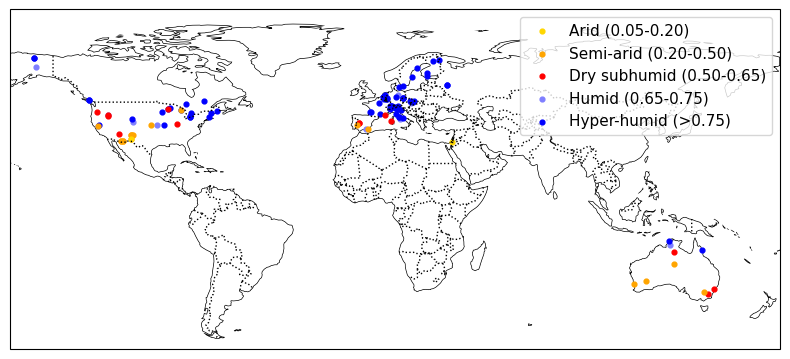

In [7]:
site_metrics_df['aridity_category'] = pd.cut(site_metrics_df['ai'], 
                                     bins=[0.05,0.20,0.50,0.65,0.75,float('inf')], 
                                     labels=['Arid','Semi-arid','Dry subhumid','Humid','Hyper-humid'])

map_colors = {
    'Hyperarid':'#FFFF00',
    'Arid':'#FFD700',
    'Semi-arid':'#FFA500',
    'Dry subhumid':'#FF0000',
    'Humid':'#7F7FFF',
    'Hyper-humid':'#0000FF'
}

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.set_extent([-160, 180, -60, 90], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='white')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linestyle=':')

for cat in ['Humid','Hyper-humid', 'Dry subhumid', 'Semi-arid', 'Arid']:
    subset = site_metrics_df[site_metrics_df['aridity_category']==cat]
    plt.scatter(subset['lon'], subset['lat'], color=map_colors[cat], label=cat, s=12, transform=ccrs.PlateCarree())

order = ['Arid','Semi-arid','Dry subhumid','Humid','Hyper-humid']
handles, labels = ax.get_legend_handles_labels()
handle_dict = dict(zip(labels, handles))
ordered_handles = [handle_dict[cat] for cat in order]
order = ['Arid (0.05-0.20)','Semi-arid (0.20-0.50)','Dry subhumid (0.50-0.65)','Humid (0.65-0.75)','Hyper-humid (>0.75)']
ax.legend(ordered_handles, order, loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

## Results 1: Overall performance

In [8]:
df['doy'] = df['TIMESTAMP'].dt.dayofyear
df['year'] = df['TIMESTAMP'].dt.year

daily_r2 = {}
seasonal_r2 = {}
spatial_r2 = {}
daily_anom_r2 = {}
annual_anom_r2 = {}

daily_rmse = {}
seasonal_rmse = {}
spatial_rmse = {}
daily_anom_rmse = {}
annual_anom_rmse = {}

for model_col in ['gpp_lstm_global', 'gpp_mlp_global', 'gpp_pmodel_global']:
    # Daily
    daily_r2[model_col] = df['GPP_NT_VUT_REF'].corr(df[model_col]) ** 2
    daily_rmse[model_col] = np.sqrt(mean_squared_error(df['GPP_NT_VUT_REF'], df[model_col]))

    # Seasonal
    seasonal_df = df.groupby(['sitename', 'doy'], as_index=False)[['GPP_NT_VUT_REF', model_col]].mean()
    seasonal_r2[model_col] = seasonal_df['GPP_NT_VUT_REF'].corr(seasonal_df[model_col]) ** 2
    seasonal_rmse[model_col] = np.sqrt(mean_squared_error(seasonal_df['GPP_NT_VUT_REF'], seasonal_df[model_col]))

    # Spatial
    spatial_df = df.groupby('sitename', as_index=False)[['GPP_NT_VUT_REF', model_col]].mean()
    spatial_r2[model_col] = spatial_df['GPP_NT_VUT_REF'].corr(spatial_df[model_col]) ** 2
    spatial_rmse[model_col] = np.sqrt(mean_squared_error(spatial_df['GPP_NT_VUT_REF'], spatial_df[model_col]))

    # Daily anomalies
    seasonal_cycle = df.groupby(['sitename', 'doy'], as_index=False)[['GPP_NT_VUT_REF', model_col]].mean()
    df_anom = pd.merge(df, seasonal_cycle, on=['sitename', 'doy'], suffixes=('', '_seasonal'))
    df_anom['obs_anom'] = df_anom['GPP_NT_VUT_REF'] - df_anom['GPP_NT_VUT_REF_seasonal']
    df_anom['pred_anom'] = df_anom[model_col] - df_anom[model_col + '_seasonal']
    daily_anom_r2[model_col] = df_anom['obs_anom'].corr(df_anom['pred_anom']) ** 2
    daily_anom_rmse[model_col] = np.sqrt(mean_squared_error(df_anom['obs_anom'], df_anom['pred_anom']))

    # Annual anomalies
    annual_df = df.groupby(['sitename', 'year'], as_index=False)[['GPP_NT_VUT_REF', model_col]].mean()
    multi_yr_mean = annual_df.groupby('sitename', as_index=False)['GPP_NT_VUT_REF'].mean().rename(columns={'GPP_NT_VUT_REF': 'obs_multi'})
    multi_yr_pred = annual_df.groupby('sitename', as_index=False)[model_col].mean().rename(columns={model_col: 'pred_multi'})
    annual_df = pd.merge(annual_df, multi_yr_mean, on='sitename')
    annual_df = pd.merge(annual_df, multi_yr_pred, on='sitename')
    annual_df['obs_anom'] = annual_df['GPP_NT_VUT_REF'] - annual_df['obs_multi']
    annual_df['pred_anom'] = annual_df[model_col] - annual_df['pred_multi']
    annual_anom_r2[model_col] = annual_df['obs_anom'].corr(annual_df['pred_anom']) ** 2
    annual_anom_rmse[model_col] = np.sqrt(mean_squared_error(annual_df['obs_anom'], annual_df['pred_anom']))

results = pd.DataFrame({
    'Metric': ['Daily', 'Seasonal', 'Spatial', 'Daily anom.', 'Annual anom.'],
    'LSTM (R2)': [
        daily_r2['gpp_lstm_global'],
        seasonal_r2['gpp_lstm_global'],
        spatial_r2['gpp_lstm_global'],
        daily_anom_r2['gpp_lstm_global'],
        annual_anom_r2['gpp_lstm_global']
    ],
    'LSTM (RMSE)': [
        daily_rmse['gpp_lstm_global'],
        seasonal_rmse['gpp_lstm_global'],
        spatial_rmse['gpp_lstm_global'],
        daily_anom_rmse['gpp_lstm_global'],
        annual_anom_rmse['gpp_lstm_global']
    ],
    'MLP (R2)': [
        daily_r2['gpp_mlp_global'],
        seasonal_r2['gpp_mlp_global'],
        spatial_r2['gpp_mlp_global'],
        daily_anom_r2['gpp_mlp_global'],
        annual_anom_r2['gpp_mlp_global']
    ],
    'MLP (RMSE)': [
        daily_rmse['gpp_mlp_global'],
        seasonal_rmse['gpp_mlp_global'],
        spatial_rmse['gpp_mlp_global'],
        daily_anom_rmse['gpp_mlp_global'],
        annual_anom_rmse['gpp_mlp_global']
    ],
    'P-model (R2)': [
        daily_r2['gpp_pmodel_global'],
        seasonal_r2['gpp_pmodel_global'],
        spatial_r2['gpp_pmodel_global'],
        daily_anom_r2['gpp_pmodel_global'],
        annual_anom_r2['gpp_pmodel_global']
    ],
    'P-model (RMSE)': [
        daily_rmse['gpp_pmodel_global'],
        seasonal_rmse['gpp_pmodel_global'],
        spatial_rmse['gpp_pmodel_global'],
        daily_anom_rmse['gpp_pmodel_global'],
        annual_anom_rmse['gpp_pmodel_global']
    ]
}).round(2)

results

Metric  LSTM (R2)  LSTM (RMSE)  MLP (R2)  MLP (RMSE)  P-model (R2)  \
0         Daily       0.74         2.01      0.74        2.00          0.62   
1      Seasonal       0.82         1.45      0.82        1.44          0.76   
2       Spatial       0.70         0.96      0.70        0.97          0.58   
3   Daily anom.       0.24         1.43      0.25        1.44          0.19   
4  Annual anom.       0.14         0.43      0.12        0.43          0.05   

   P-model (RMSE)  
0            2.40  
1            1.71  
2            1.12  
3            1.69  
4            0.46

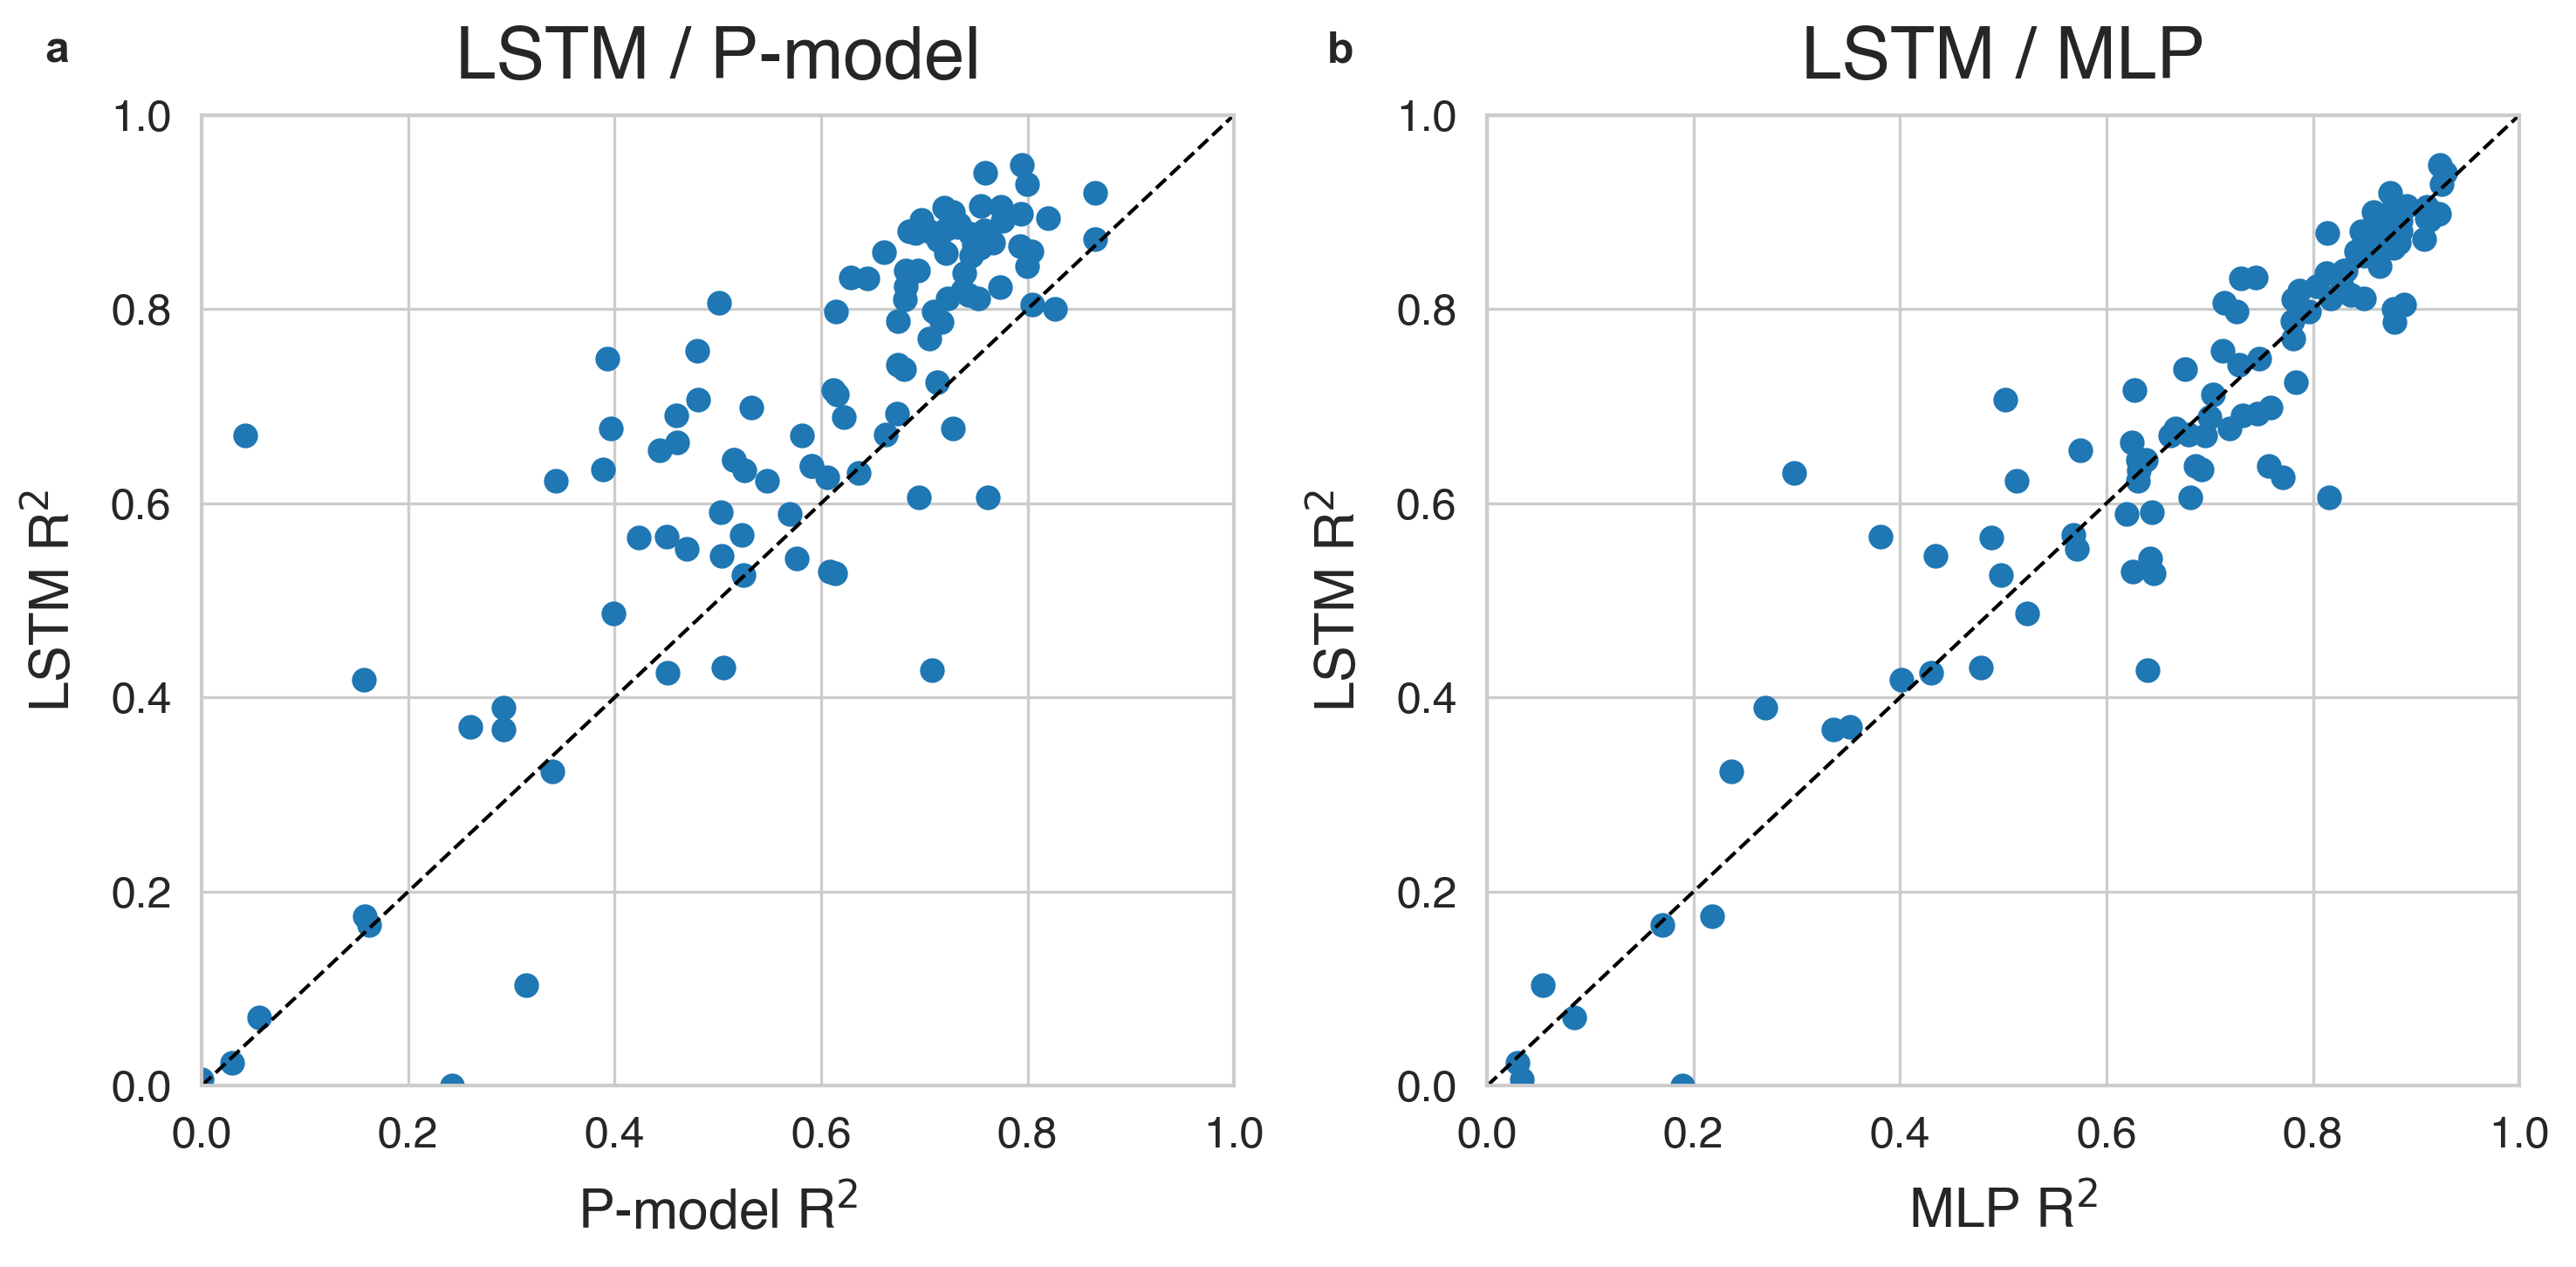

In [9]:
set_publication_style()
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].scatter(site_metrics_df['pmodel_global_r2'], site_metrics_df['lstm_global_r2'])
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel(r'P-model R$^2$')
axes[0].set_ylabel(r'LSTM R$^2$')
axes[0].set_title('LSTM / P-model')
axes[1].scatter(site_metrics_df['mlp_global_r2'], site_metrics_df['lstm_global_r2'])
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel(r'MLP R$^2$')
axes[1].set_ylabel(r'LSTM R$^2$')
axes[1].set_title('LSTM / MLP')
fig.text(0.025, 0.96, 'a', fontweight='heavy', fontfamily='sans-serif', ha='left', va='top')
fig.text(0.515, 0.96, 'b', fontweight='heavy', fontfamily='sans-serif', ha='left', va='top')
plt.tight_layout()
plt.show()

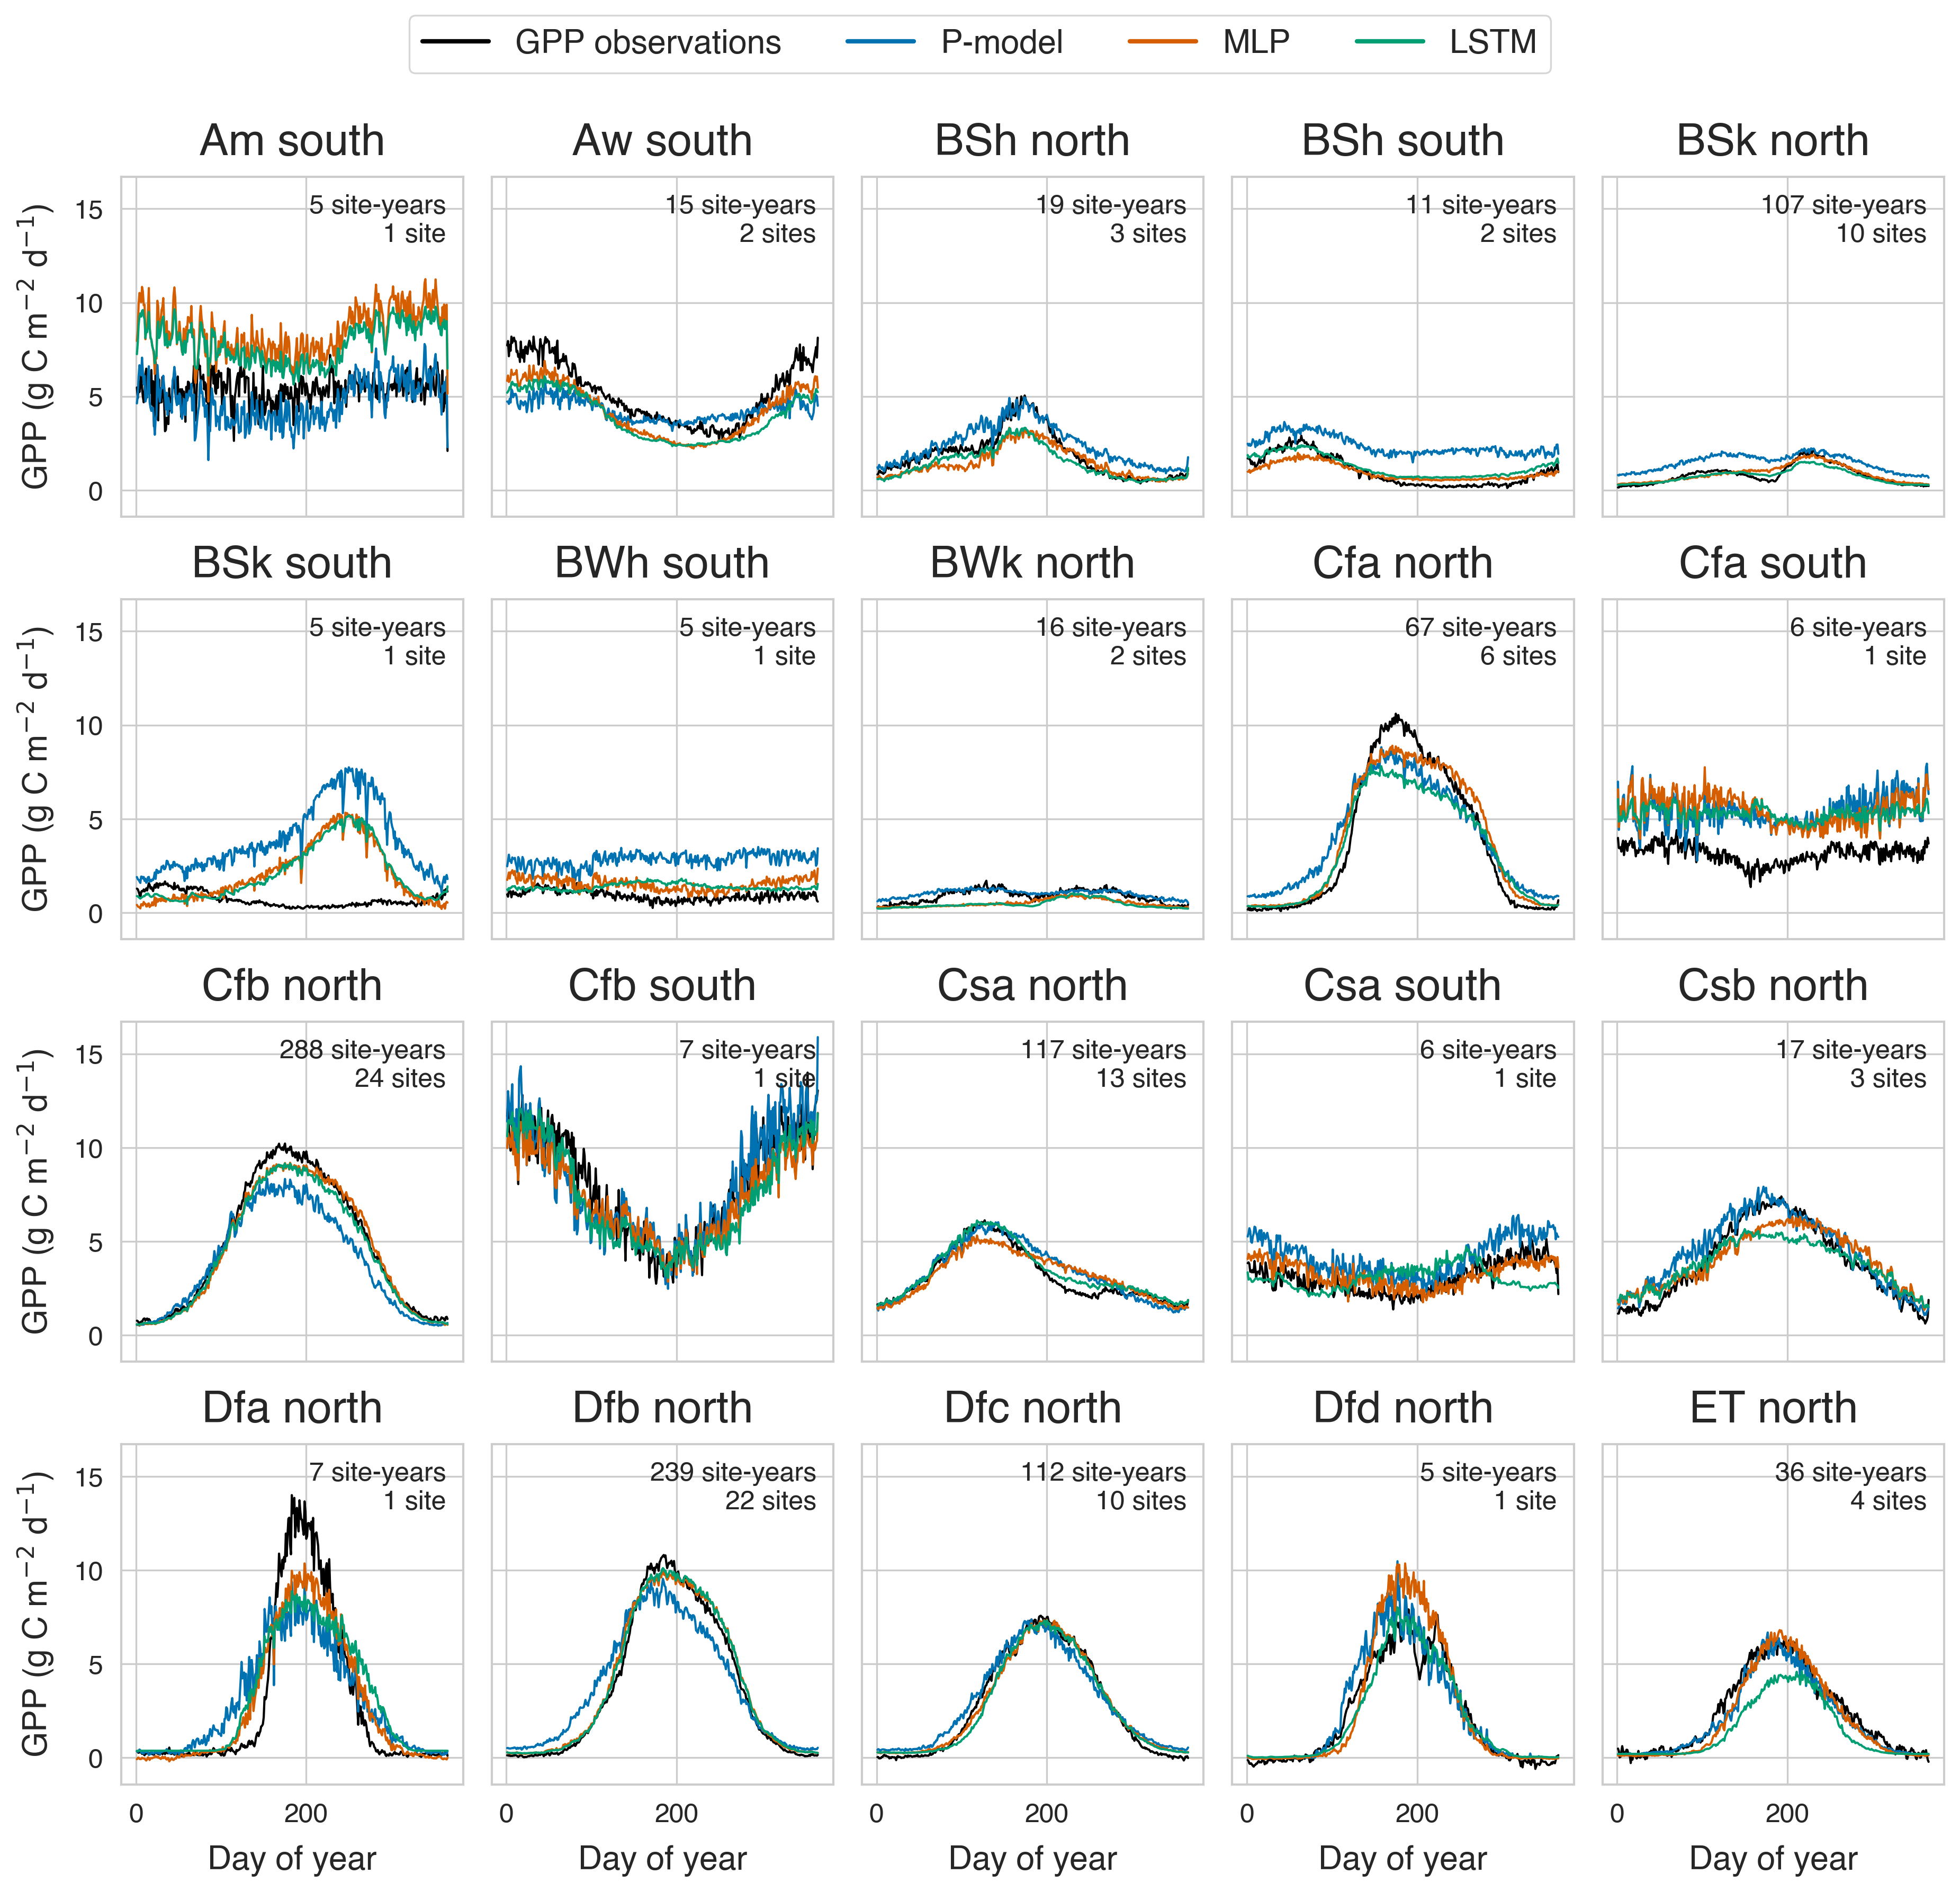

In [10]:
set_publication_style()
seasonal = df.groupby(['koeppen_hemisphere','doy'])[['GPP_NT_VUT_REF','gpp_lstm_global','gpp_mlp_global','gpp_pmodel_global']].mean().reset_index()
site_counts = df.groupby('koeppen_hemisphere')['sitename'].nunique()
koeppen_values = sorted(site_counts.index.tolist())
ncols = 5
nrows = (len(koeppen_values)+ncols-1)//ncols
fig,axes = plt.subplots(nrows,ncols,figsize=(2.5*ncols,3*nrows),sharex=True,sharey=True)
axes = axes.flatten()
for i,koeppen in enumerate(koeppen_values):
    sub = seasonal[seasonal['koeppen_hemisphere']==koeppen].sort_values('doy')
    axes[i].plot(sub['doy'],sub['GPP_NT_VUT_REF'],label='GPP observations',color='black',lw=1)
    axes[i].plot(sub['doy'],sub['gpp_pmodel_global'],label='P-model',color=colors['P-model'],lw=1)
    axes[i].plot(sub['doy'],sub['gpp_mlp_global'],label='MLP',color=colors['MLP'],lw=1)
    axes[i].plot(sub['doy'],sub['gpp_lstm_global'],label='LSTM',color=colors['LSTM'],lw=1)
    axes[i].set_title(koeppen)
    if i%ncols==0:
        axes[i].set_ylabel('GPP (g C m$^{-2}$ d$^{-1}$)')
    site_years = df[df['koeppen_hemisphere']==koeppen][['sitename','year']].drop_duplicates().shape[0]
    site_count = df[df['koeppen_hemisphere']==koeppen]['sitename'].nunique()
    if site_count==1:
        site_count='1 site'
    else:
        site_count=f'{site_count} sites'
    axes[i].text(0.95,0.95,f'{site_years} site-years\n{site_count}',transform=axes[i].transAxes,ha='right',va='top')
for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])
n_plots = len(koeppen_values)
label_indices = []
for col in range(ncols):
    bottom_index = (nrows-1)*ncols+col
    if bottom_index<n_plots:
        label_indices.append(bottom_index)
    elif nrows>=2:
        second_last_index = (nrows-2)*ncols+col
        if second_last_index<n_plots:
            label_indices.append(second_last_index)
for idx in range(n_plots):
    if idx in label_indices:
        axes[idx].set_xlabel('Day of year')
    else:
        axes[idx].set_xlabel('')
lines = [plt.Line2D([],[],color='black',lw=2,label='GPP observations'),plt.Line2D([],[],color=colors['P-model'],lw=2,label='P-model'),plt.Line2D([],[],color=colors['MLP'],lw=2,label='MLP'),plt.Line2D([],[],color=colors['LSTM'],lw=2,label='LSTM')]
fig.legend(handles=lines,loc='upper center',bbox_to_anchor=(0.5,1.0),ncol=4)
fig.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Results 2: Temporal patterns in model error

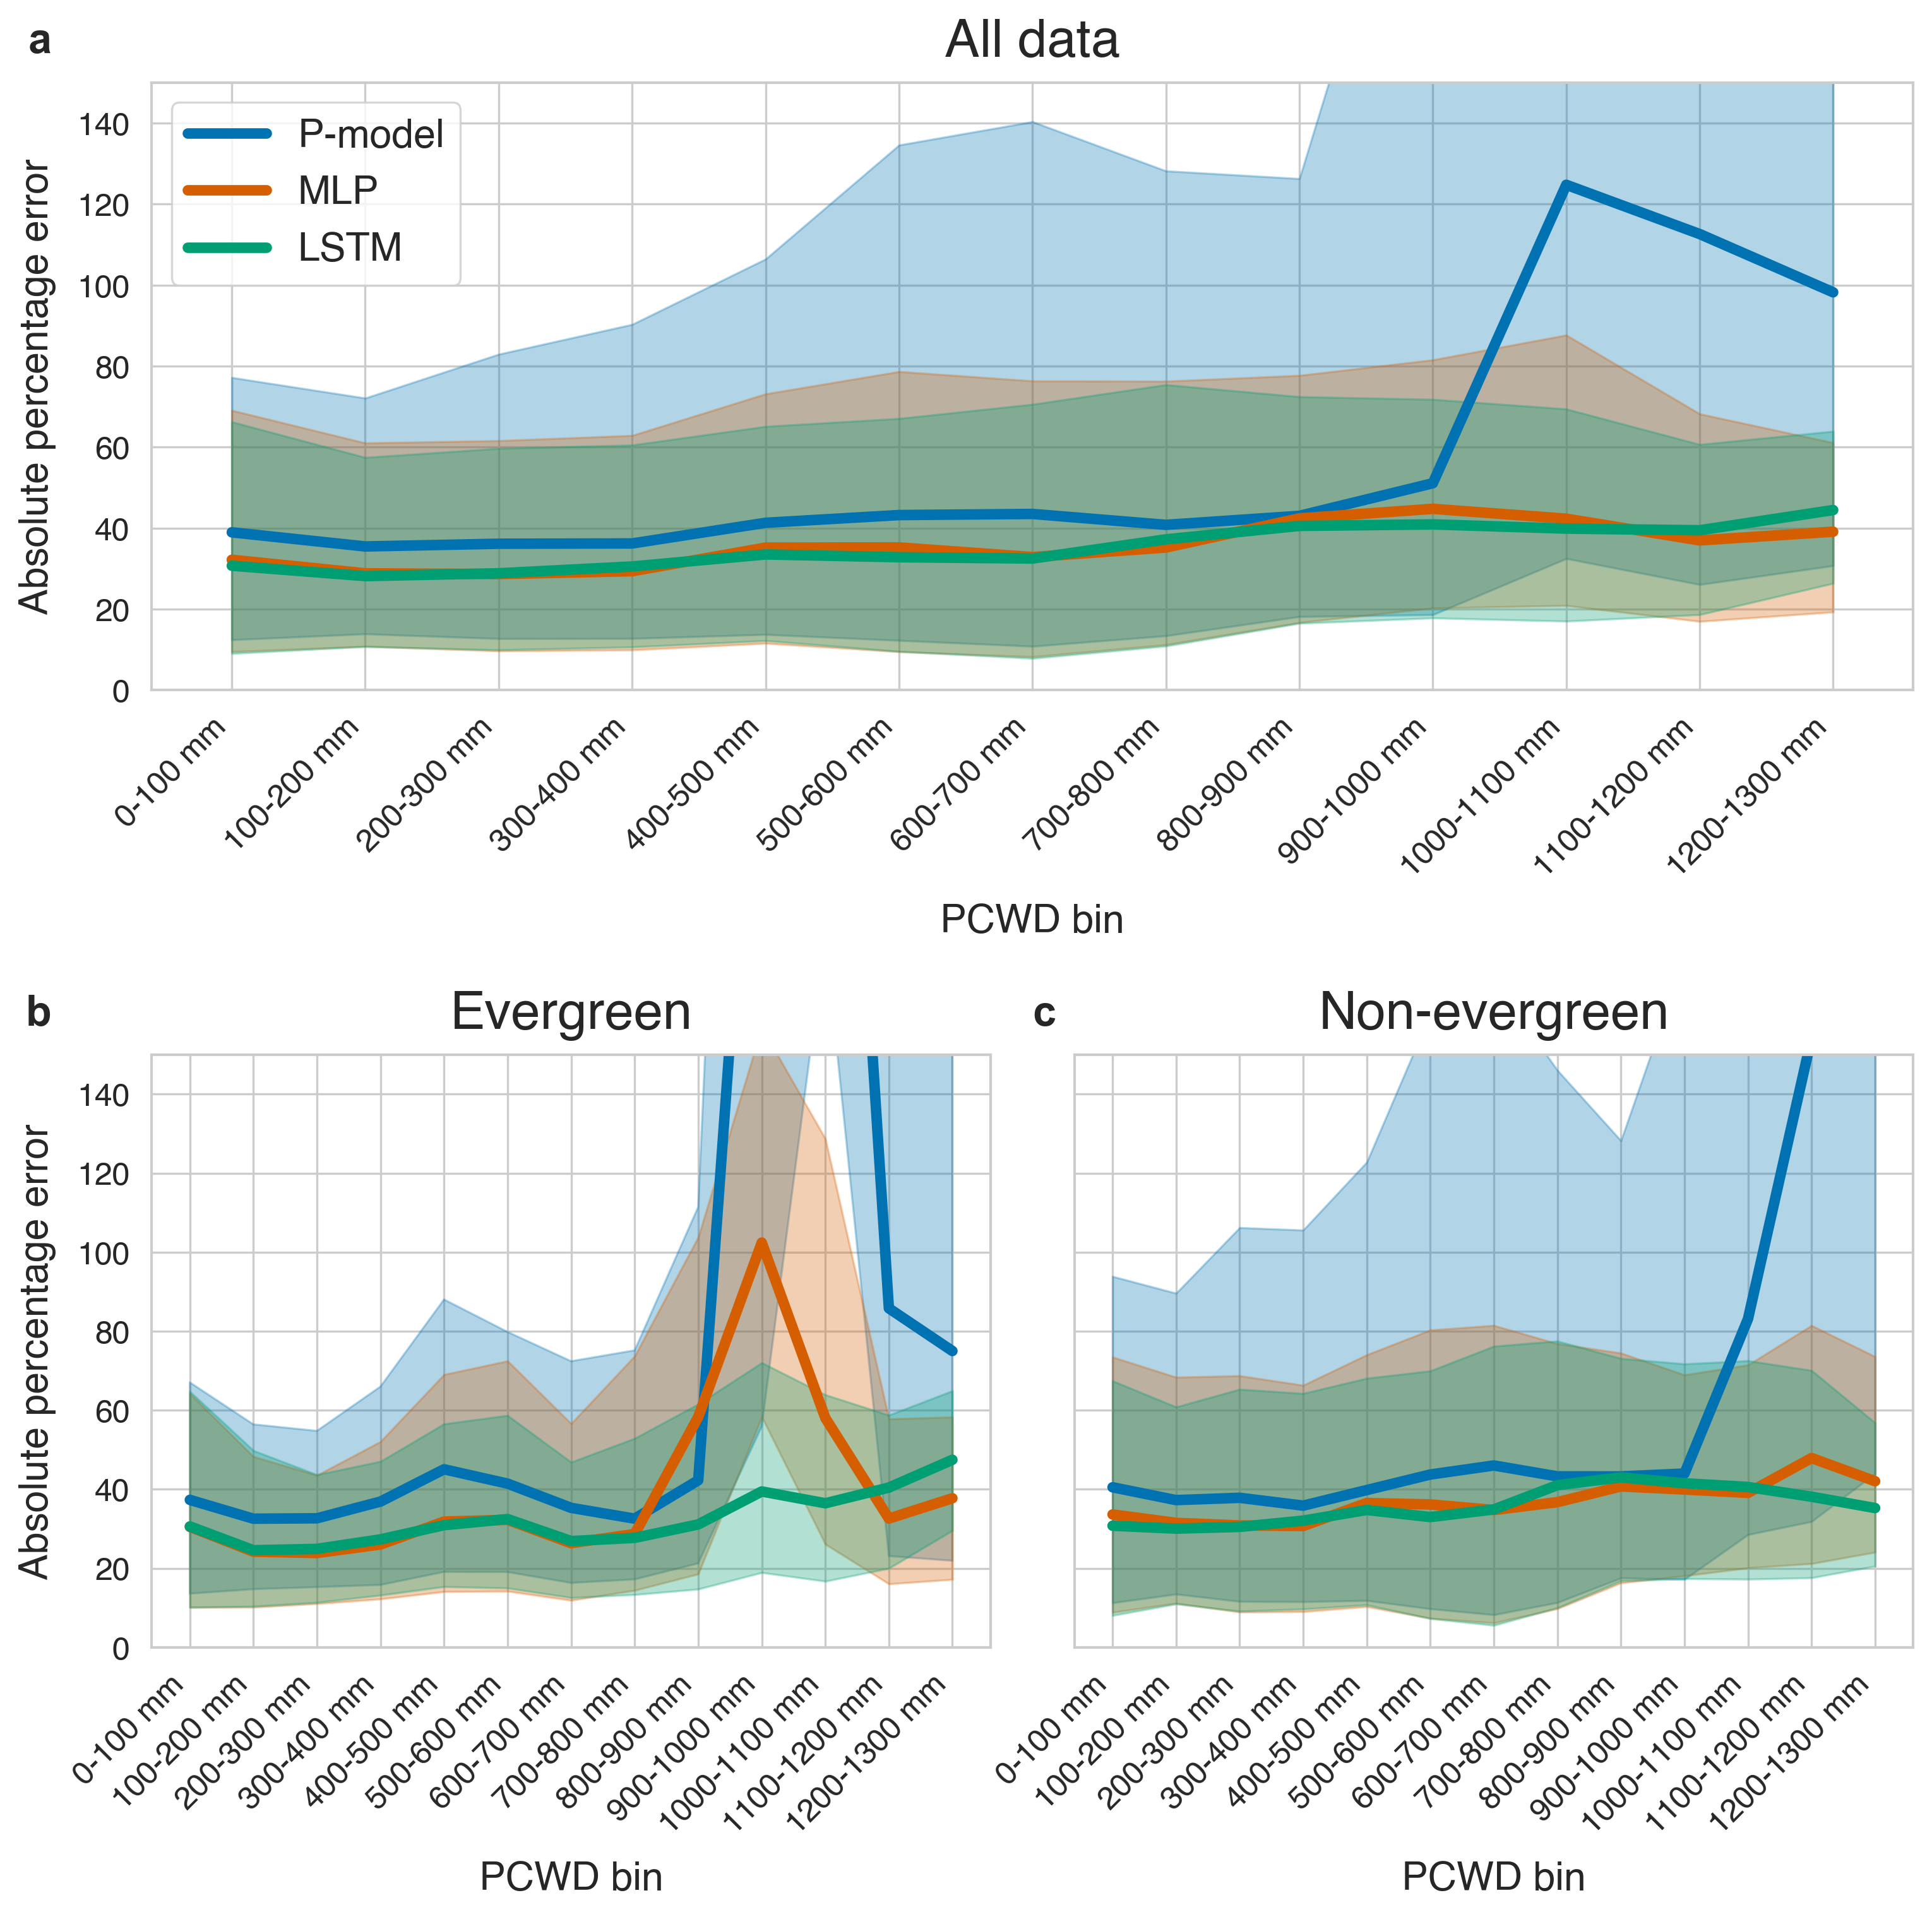

In [11]:
set_publication_style(figsize=(12,6))
fig = plt.figure(figsize=(12,15))

# Increase vertical space between top and bottom plots by setting hspace to 0.5
outer_gs = fig.add_gridspec(2,1, height_ratios=[1,2], hspace=0.4)
ax_all = fig.add_subplot(outer_gs[0])

bottom_gs = outer_gs[1].subgridspec(2,2, hspace=0.05, wspace=0.1)

ax1 = fig.add_subplot(bottom_gs[0,0])
ax2 = fig.add_subplot(bottom_gs[0,1], sharey=ax1)
ax2.tick_params(labelleft=False)

df_subset = df.copy()
df_subset = df_subset[df_subset['pcwd']<=1300]
bins = np.arange(0,1301,100)
df_subset['lstm_global_mape'] = np.abs(df_subset['GPP_NT_VUT_REF'] - df_subset['gpp_lstm_global']) / df_subset['GPP_NT_VUT_REF'] * 100
df_subset['mlp_global_mape'] = np.abs(df_subset['GPP_NT_VUT_REF'] - df_subset['gpp_mlp_global']) / df_subset['GPP_NT_VUT_REF'] * 100
df_subset['pmodel_mape'] = np.abs(df_subset['GPP_NT_VUT_REF'] - df_subset['gpp_pmodel_global']) / df_subset['GPP_NT_VUT_REF'] * 100
df_subset['pcwd_bin'] = pd.cut(df_subset['pcwd'], bins=bins, right=False, include_lowest=True)

def compute_summary_stats(d):
    d_long = d.melt(id_vars=['pcwd_bin'], value_vars=['mlp_global_mape','lstm_global_mape','pmodel_mape'],
                    var_name='Model', value_name='Global MAPE')
    d_long['Model'] = d_long['Model'].map({'mlp_global_mape':'MLP','lstm_global_mape':'LSTM','pmodel_mape':'P-model'})
    s = d_long.groupby(['pcwd_bin','Model'])['Global MAPE'].agg(median='median', q1=lambda x: x.quantile(0.25),
                                                                 q3=lambda x: x.quantile(0.75)).reset_index()
    s['pcwd_bin_mid'] = s['pcwd_bin'].apply(lambda x: x.right)
    return s

def filter_and_summarize(d):
    c = d['pcwd_bin'].value_counts()
    v = c[c >= 100].index
    d = d[d['pcwd_bin'].isin(v)]
    s = compute_summary_stats(d)
    s['count'] = s['pcwd_bin'].map(c)
    s['pcwd_bin'] = s['pcwd_bin'].cat.remove_unused_categories()
    return s

df_evergreen = df_subset[df_subset['is_evergreen']]
df_non_evergreen = df_subset[~df_subset['is_evergreen']]

s_evergreen = filter_and_summarize(df_evergreen)
s_non_evergreen = filter_and_summarize(df_non_evergreen)
s_all = filter_and_summarize(df_subset)

def plot_summary(a, d, t):
    d = d.sort_values('pcwd_bin_mid')
    unique_bins = d.drop_duplicates('pcwd_bin').sort_values('pcwd_bin_mid')
    x_positions = unique_bins['pcwd_bin'].apply(lambda x: x.right)
    bin_labels = []
    for _, row in unique_bins.iterrows():
        left = int(row['pcwd_bin'].left)
        right = int(row['pcwd_bin'].right)
        bin_labels.append(f"{left}-{right} mm")
    for m in ['P-model','MLP','LSTM']:
        subset = d[d['Model'] == m]
        x = subset['pcwd_bin_mid']
        y = subset['median']
        y1 = subset['q1']
        y3 = subset['q3']
        a.plot(x, y, label=m, color=colors.get(m))
        a.fill_between(x, y1, y3, alpha=0.3, color=colors.get(m))
    a.set_title(t)
    a.set_xticks(x_positions)
    a.set_xticklabels(bin_labels, rotation=45, ha='right')
    a.set_ylim(0,150)

plot_summary(ax_all, s_all, 'All data')
ax_all.set_xlabel('PCWD bin')
ax_all.set_ylabel('Absolute percentage error')
ax_all.legend()

plot_summary(ax1, s_evergreen, 'Evergreen')
plot_summary(ax2, s_non_evergreen, 'Non-evergreen')
ax1.set_ylabel('Absolute percentage error')
ax1.set_xlabel('PCWD bin')
ax2.set_xlabel('PCWD bin')

# Add subplot labels to the three axes. For ax2, shift the label upward to avoid overlapping the title.
ax_all.text(-0.07, 1.05, 'a', transform=ax_all.transAxes, fontsize=16, fontweight='heavy', fontfamily='sans-serif')
ax1.text(-0.15, 1.05, 'b', transform=ax1.transAxes, fontsize=16, fontweight='heavy', fontfamily='sans-serif')
ax2.text(-0.05, 1.05, 'c', transform=ax2.transAxes, fontsize=16, fontweight='heavy', fontfamily='sans-serif')

plt.show()

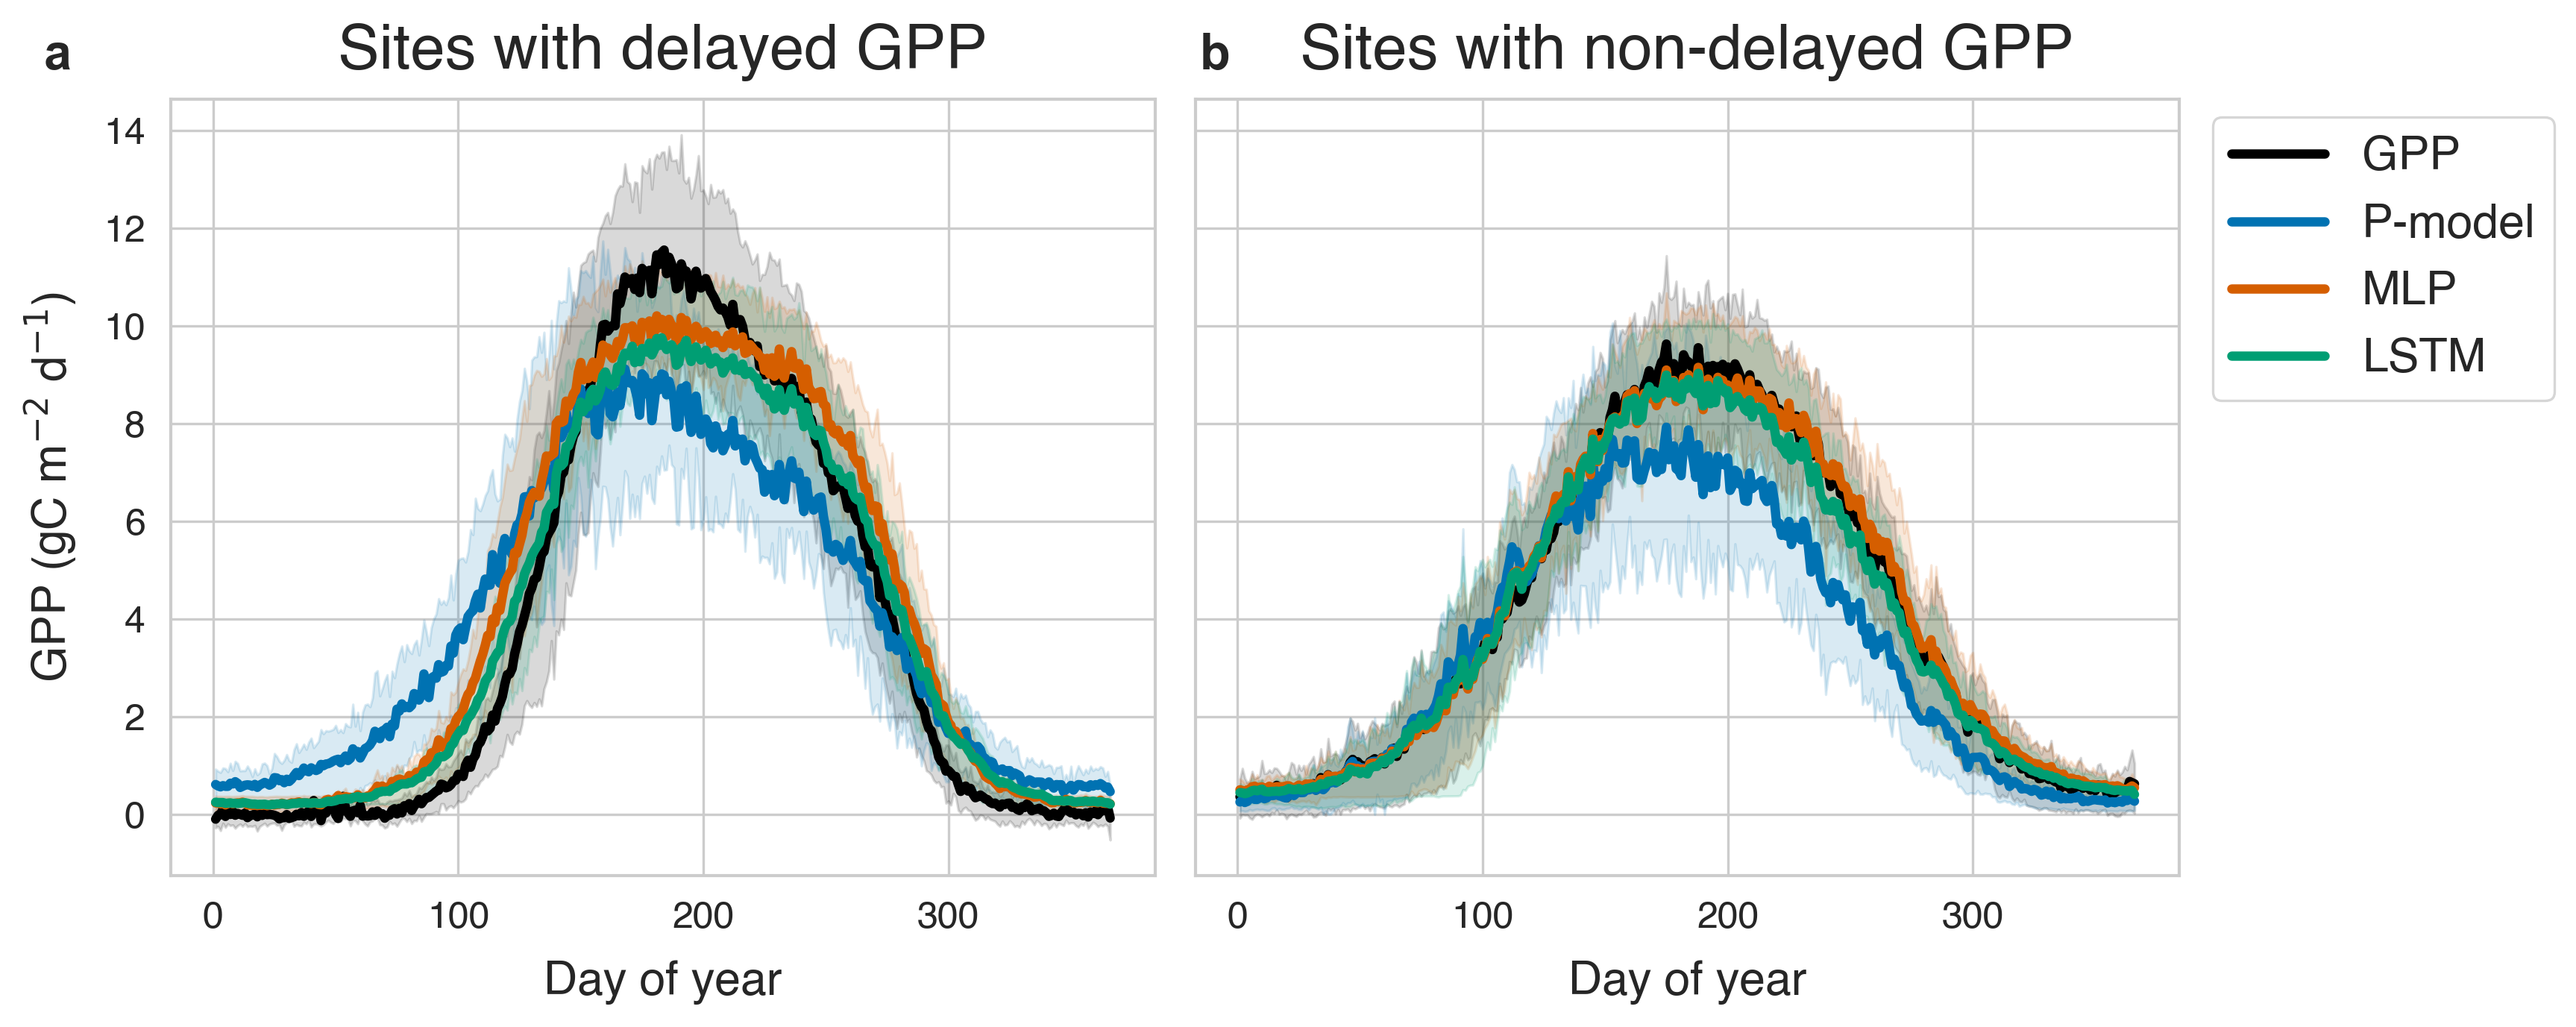

In [12]:
lw_default = 3
lw_lstm = 3
alpha_shade = 0.15

df_delayed = df[df['cold_acclimation_type'] == 'cold_delayedgpp']
df_non_delayed = df[df['cold_acclimation_type'] == 'cold_nodelayedgpp']

cols = ['GPP_NT_VUT_REF', 'gpp_lstm_global', 'gpp_mlp_global', 'gpp_pmodel_global']

delayed_cycle = (
    df_delayed.groupby('doy')[cols]
    .mean()
    .reset_index()
    .sort_values('doy')
)
non_delayed_cycle = (
    df_non_delayed.groupby('doy')[cols]
    .mean()
    .reset_index()
    .sort_values('doy')
)

delayed_quantiles = {}
non_delayed_quantiles = {}
for col in cols:
    q25_delayed = (
        df_delayed.groupby('doy')[col]
        .quantile(0.25)
        .reset_index()
        .sort_values('doy')
    )
    q75_delayed = (
        df_delayed.groupby('doy')[col]
        .quantile(0.75)
        .reset_index()
        .sort_values('doy')
    )
    delayed_quantiles[col] = {'q25': q25_delayed, 'q75': q75_delayed}
    
    q25_non_delayed = (
        df_non_delayed.groupby('doy')[col]
        .quantile(0.25)
        .reset_index()
        .sort_values('doy')
    )
    q75_non_delayed = (
        df_non_delayed.groupby('doy')[col]
        .quantile(0.75)
        .reset_index()
        .sort_values('doy')
    )
    non_delayed_quantiles[col] = {'q25': q25_non_delayed, 'q75': q75_non_delayed}

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True, sharey=True)

axes[0].fill_between(
    delayed_quantiles['GPP_NT_VUT_REF']['q25']['doy'],
    delayed_quantiles['GPP_NT_VUT_REF']['q25']['GPP_NT_VUT_REF'],
    delayed_quantiles['GPP_NT_VUT_REF']['q75']['GPP_NT_VUT_REF'],
    color='black',
    alpha=alpha_shade
)
axes[0].plot(delayed_cycle['doy'], delayed_cycle['GPP_NT_VUT_REF'], label='GPP', color='black', linestyle='-', linewidth=lw_default)

axes[0].fill_between(
    delayed_quantiles['gpp_pmodel_global']['q25']['doy'],
    delayed_quantiles['gpp_pmodel_global']['q25']['gpp_pmodel_global'],
    delayed_quantiles['gpp_pmodel_global']['q75']['gpp_pmodel_global'],
    color=colors['P-model'],
    alpha=alpha_shade
)
axes[0].plot(delayed_cycle['doy'], delayed_cycle['gpp_pmodel_global'], label='P-model', color=colors['P-model'], linestyle='-', linewidth=lw_default)

axes[0].fill_between(
    delayed_quantiles['gpp_mlp_global']['q25']['doy'],
    delayed_quantiles['gpp_mlp_global']['q25']['gpp_mlp_global'],
    delayed_quantiles['gpp_mlp_global']['q75']['gpp_mlp_global'],
    color=colors['MLP'],
    alpha=alpha_shade
)
axes[0].plot(delayed_cycle['doy'], delayed_cycle['gpp_mlp_global'], label='MLP', color=colors['MLP'], linestyle='-', linewidth=lw_default)

axes[0].fill_between(
    delayed_quantiles['gpp_lstm_global']['q25']['doy'],
    delayed_quantiles['gpp_lstm_global']['q25']['gpp_lstm_global'],
    delayed_quantiles['gpp_lstm_global']['q75']['gpp_lstm_global'],
    color=colors['LSTM'],
    alpha=alpha_shade
)
axes[0].plot(delayed_cycle['doy'], delayed_cycle['gpp_lstm_global'], label='LSTM', color=colors['LSTM'], linestyle='-', linewidth=lw_lstm)

axes[0].set_title('Sites with delayed GPP')
axes[0].set_ylabel('GPP (gC m$^{-2}$ d$^{-1}$)')
axes[0].grid(True)
axes[0].tick_params(axis='both', which='major')
axes[0].set_xlabel('Day of year')

axes[1].fill_between(
    non_delayed_quantiles['GPP_NT_VUT_REF']['q25']['doy'],
    non_delayed_quantiles['GPP_NT_VUT_REF']['q25']['GPP_NT_VUT_REF'],
    non_delayed_quantiles['GPP_NT_VUT_REF']['q75']['GPP_NT_VUT_REF'],
    color='black',
    alpha=alpha_shade
)
axes[1].plot(non_delayed_cycle['doy'], non_delayed_cycle['GPP_NT_VUT_REF'], label='GPP', color='black', linestyle='-', linewidth=lw_default)

axes[1].fill_between(
    non_delayed_quantiles['gpp_pmodel_global']['q25']['doy'],
    non_delayed_quantiles['gpp_pmodel_global']['q25']['gpp_pmodel_global'],
    non_delayed_quantiles['gpp_pmodel_global']['q75']['gpp_pmodel_global'],
    color=colors['P-model'],
    alpha=alpha_shade
)
axes[1].plot(non_delayed_cycle['doy'], non_delayed_cycle['gpp_pmodel_global'], label='P-model', color=colors['P-model'], linestyle='-', linewidth=lw_default)

axes[1].fill_between(
    non_delayed_quantiles['gpp_mlp_global']['q25']['doy'],
    non_delayed_quantiles['gpp_mlp_global']['q25']['gpp_mlp_global'],
    non_delayed_quantiles['gpp_mlp_global']['q75']['gpp_mlp_global'],
    color=colors['MLP'],
    alpha=alpha_shade
)
axes[1].plot(non_delayed_cycle['doy'], non_delayed_cycle['gpp_mlp_global'], label='MLP', color=colors['MLP'], linestyle='-', linewidth=lw_default)

axes[1].fill_between(
    non_delayed_quantiles['gpp_lstm_global']['q25']['doy'],
    non_delayed_quantiles['gpp_lstm_global']['q25']['gpp_lstm_global'],
    non_delayed_quantiles['gpp_lstm_global']['q75']['gpp_lstm_global'],
    color=colors['LSTM'],
    alpha=alpha_shade
)
axes[1].plot(non_delayed_cycle['doy'], non_delayed_cycle['gpp_lstm_global'], label='LSTM', color=colors['LSTM'], linestyle='-', linewidth=lw_lstm)

axes[1].set_title('Sites with non-delayed GPP')
axes[1].grid(True)
axes[1].tick_params(axis='both', which='major')
axes[1].set_xlabel('Day of year')

pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
fig.text(pos0.x0 - 0.085, pos0.y1 + 0.025, 'a', fontsize=16, ha='right', va='top', fontweight='heavy', fontfamily='sans-serif')
fig.text(pos1.x0 + 0.01, pos1.y1 + 0.025, 'b', fontsize=16, ha='right', va='top', fontweight='heavy', fontfamily='sans-serif')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.16, 0.85))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Results 3: Spatial patterns in model performance

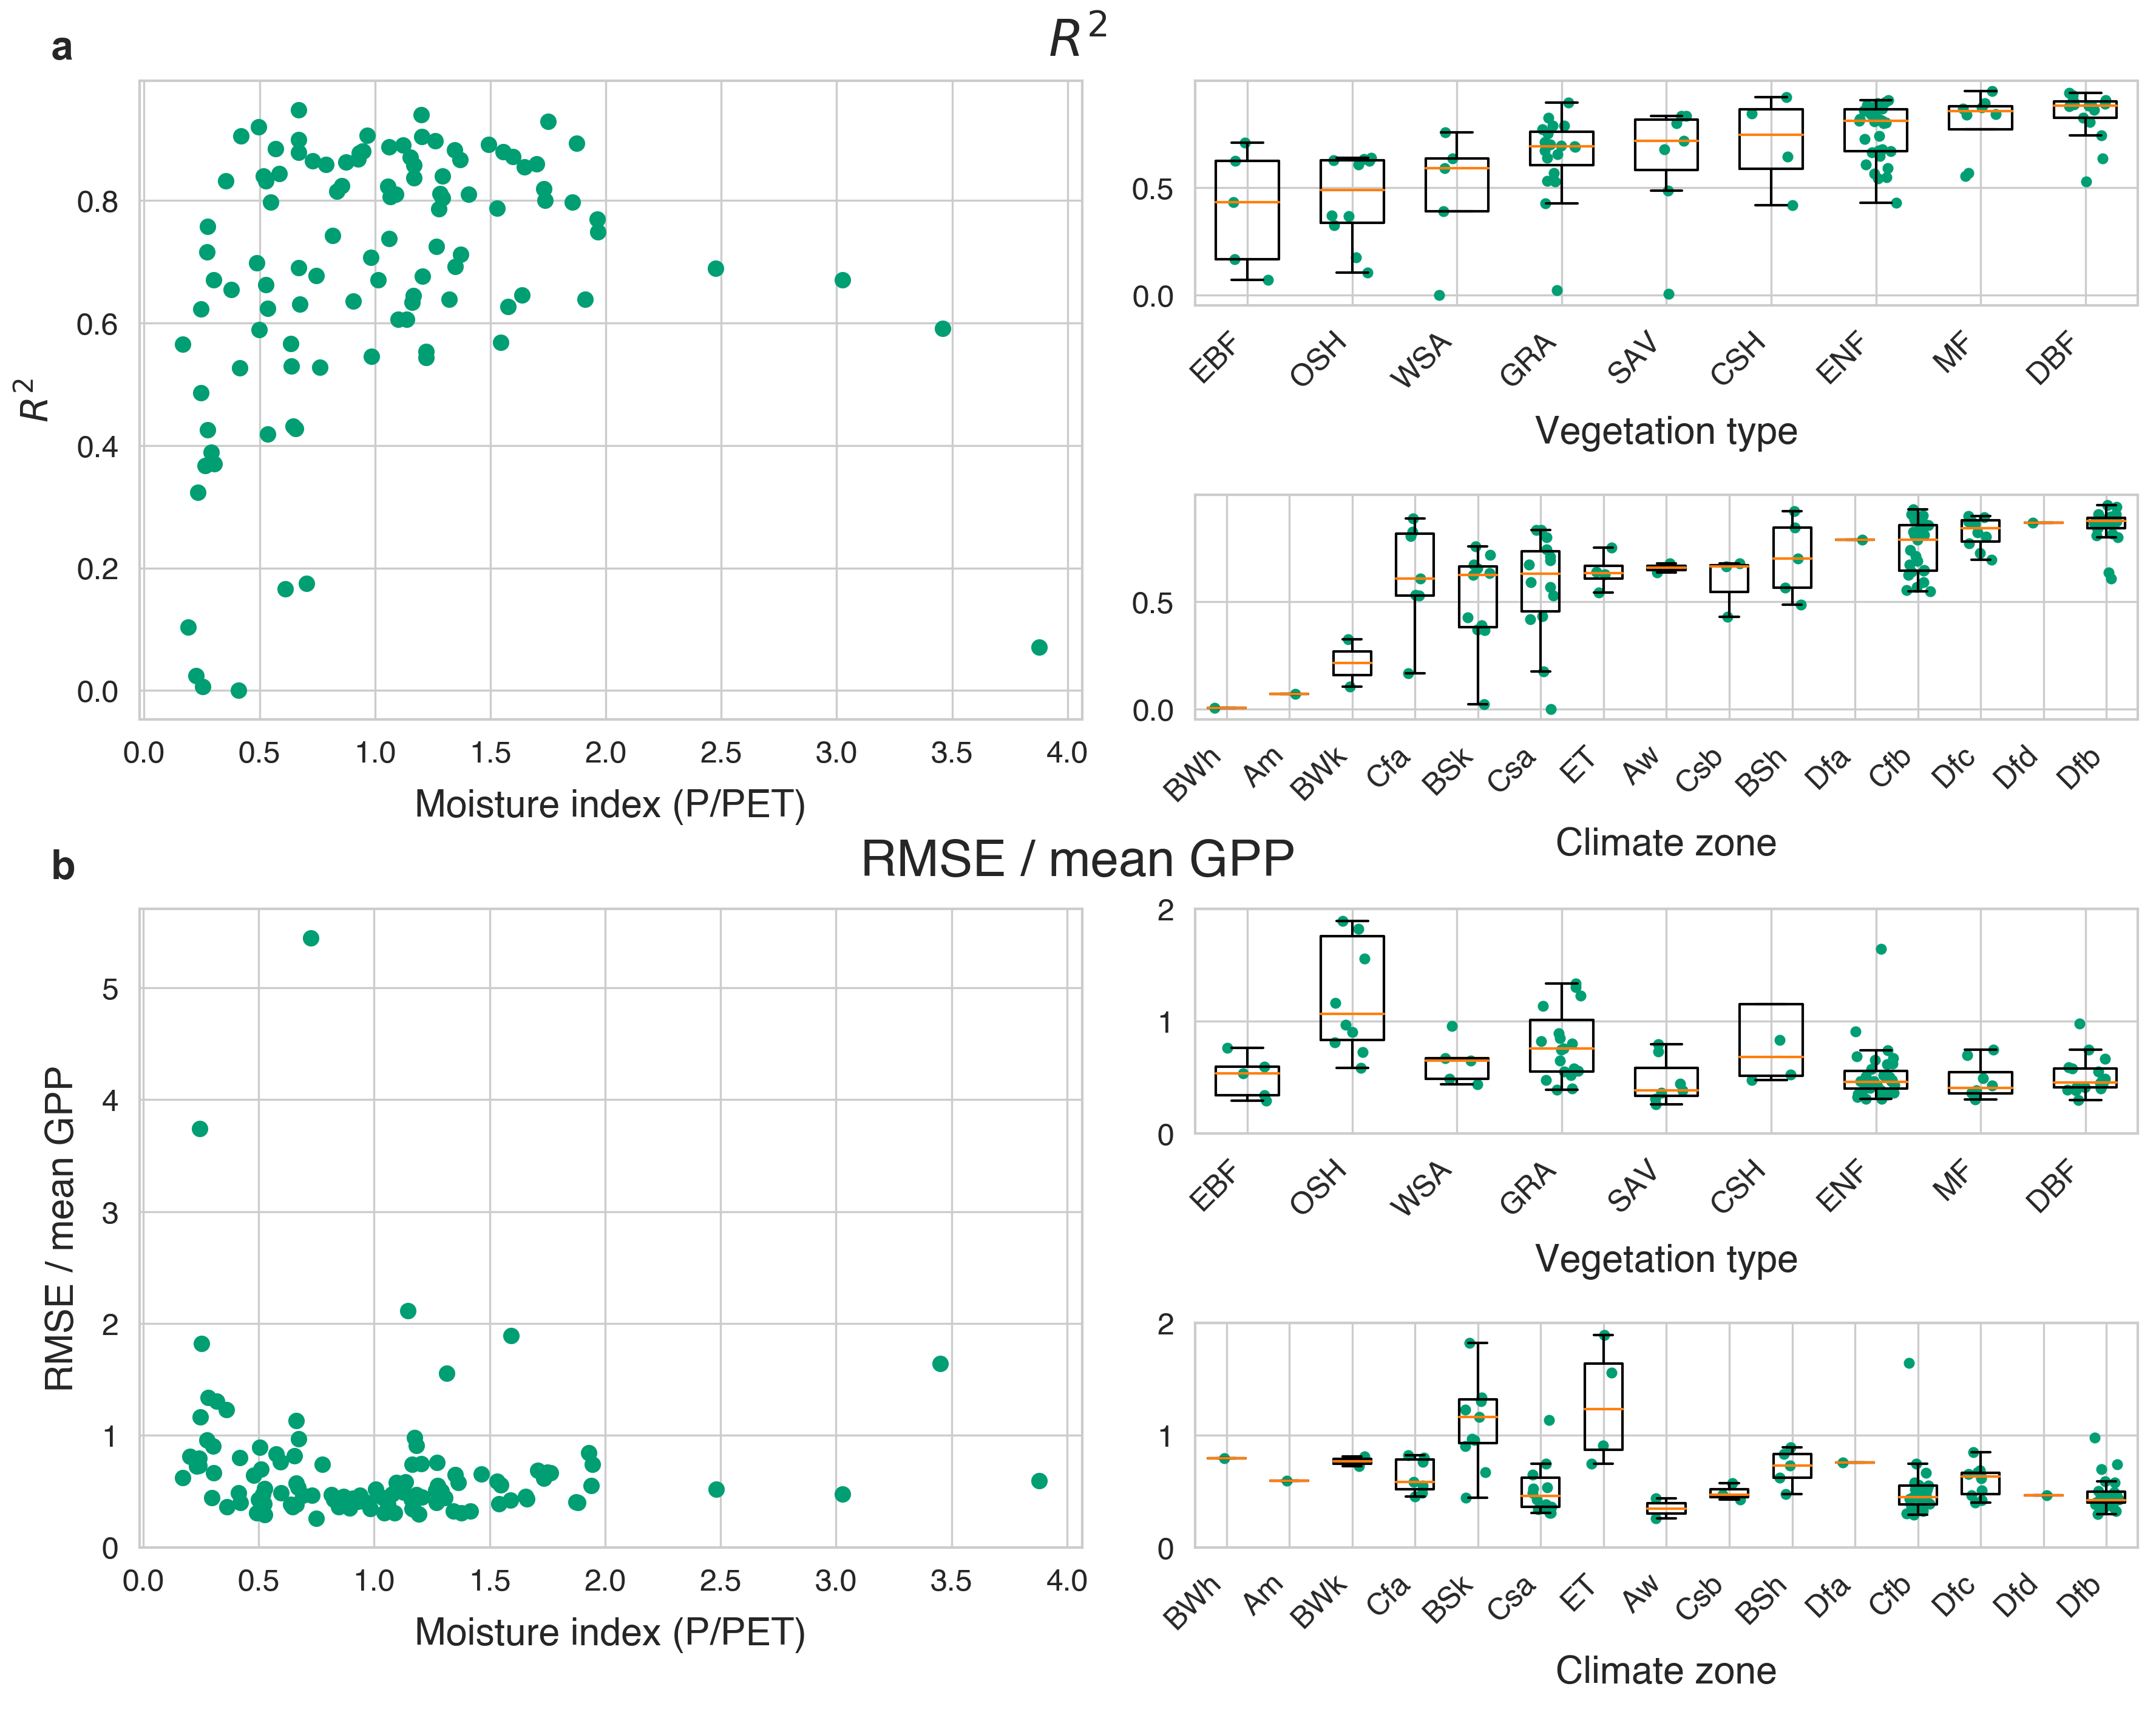

In [13]:
set_publication_style()
df_subset = site_metrics_df.copy()
df_subset['rmse_norm'] = df_subset['lstm_global_rmse'] / df_subset['mean_gpp']
veg_medians = df_subset.groupby('igbp_land_use')['lstm_global_r2'].median()
veg_order = veg_medians.sort_values().index.tolist()
climate_medians = df_subset.groupby('koeppen_code')['lstm_global_r2'].median()
climate_order = climate_medians.sort_values().index.tolist()
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1])
ax_r2_moisture = fig.add_subplot(gs[0:2, 0])
ax_r2_veg = fig.add_subplot(gs[0, 1])
ax_r2_climate = fig.add_subplot(gs[1, 1])
ax_rmse_moisture = fig.add_subplot(gs[2:4, 0])
ax_rmse_veg = fig.add_subplot(gs[2, 1])
ax_rmse_climate = fig.add_subplot(gs[3, 1])
ai_values = df_subset['ai']
r2_values = df_subset['lstm_global_r2']
for ai, val in zip(ai_values, r2_values):
    if val is not None:
        ax_r2_moisture.scatter(ai + np.random.uniform(-0.02, 0.02), val, color=colors['LSTM'], marker='.', s=130)
ax_r2_moisture.set_ylabel(r'$R^2$')
ax_r2_moisture.set_xlabel('Moisture index (P/PET)')
data_r2_veg = [df_subset.loc[df_subset['igbp_land_use'] == cat, 'lstm_global_r2'].dropna() for cat in veg_order]
x_positions = np.arange(len(data_r2_veg))
ax_r2_veg.boxplot(data_r2_veg, positions=x_positions, widths=0.6, showfliers=False)
for i, d in enumerate(data_r2_veg):
    if len(d) > 0:
        ax_r2_veg.scatter(np.full(len(d), i) + np.random.uniform(-0.2, 0.2, len(d)), d, color=colors['LSTM'], marker='.', s=50)
ax_r2_veg.set_xticks(x_positions)
ax_r2_veg.set_xticklabels(veg_order, rotation=45, ha='right')
ax_r2_veg.set_xlabel('Vegetation type')
data_r2_climate = [df_subset.loc[df_subset['koeppen_code'] == cat, 'lstm_global_r2'].dropna() for cat in climate_order]
x_positions = np.arange(len(data_r2_climate))
ax_r2_climate.boxplot(data_r2_climate, positions=x_positions, widths=0.6, showfliers=False)
for i, d in enumerate(data_r2_climate):
    if len(d) > 0:
        ax_r2_climate.scatter(np.full(len(d), i) + np.random.uniform(-0.2, 0.2, len(d)), d, color=colors['LSTM'], marker='.', s=50)
ax_r2_climate.set_xticks(x_positions)
ax_r2_climate.set_xticklabels(climate_order, rotation=45, ha='right')
ax_r2_climate.set_xlabel('Climate zone')
rmse_values = df_subset['rmse_norm']
for ai, val in zip(ai_values, rmse_values):
    if val is not None:
        ax_rmse_moisture.scatter(ai + np.random.uniform(-0.02, 0.02), val, color=colors['LSTM'], marker='.', s=130)
ax_rmse_moisture.set_ylabel('RMSE / mean GPP')
ax_rmse_moisture.set_xlabel('Moisture index (P/PET)')
data_rmse_veg = [df_subset.loc[df_subset['igbp_land_use'] == cat, 'rmse_norm'].dropna() for cat in veg_order]
x_positions = np.arange(len(data_rmse_veg))
ax_rmse_veg.boxplot(data_rmse_veg, positions=x_positions, widths=0.6, showfliers=False)
for i, d in enumerate(data_rmse_veg):
    if len(d) > 0:
        ax_rmse_veg.scatter(np.full(len(d), i) + np.random.uniform(-0.2, 0.2, len(d)), d, color=colors['LSTM'], marker='.', s=50)
ax_rmse_veg.set_xticks(x_positions)
ax_rmse_veg.set_xticklabels(veg_order, rotation=45, ha='right')
ax_rmse_veg.set_xlabel('Vegetation type')
data_rmse_climate = [df_subset.loc[df_subset['koeppen_code'] == cat, 'rmse_norm'].dropna() for cat in climate_order]
x_positions = np.arange(len(data_rmse_climate))
ax_rmse_climate.boxplot(data_rmse_climate, positions=x_positions, widths=0.6, showfliers=False)
for i, d in enumerate(data_rmse_climate):
    if len(d) > 0:
        ax_rmse_climate.scatter(np.full(len(d), i) + np.random.uniform(-0.2, 0.2, len(d)), d, color=colors['LSTM'], marker='.', s=50)
ax_rmse_climate.set_xticks(x_positions)
ax_rmse_climate.set_xticklabels(climate_order, rotation=45, ha='right')
ax_rmse_climate.set_xlabel('Climate zone')
ax_rmse_veg.set_ylim(0, 2)
ax_rmse_climate.set_ylim(0, 2)

fig.text(0.03, 0.92, 'a', ha='left', va='center', fontsize=16, fontweight='heavy', fontfamily='sans-serif')
fig.text(0.03, 0.47, 'b', ha='left', va='center', fontsize=16, fontweight='heavy', fontfamily='sans-serif')
plt.tight_layout(rect=[0, 0, 1, 0.92])
fig.text(0.5, 0.91, r'$R^2$', ha='center', va='bottom', fontsize=20)
fig.text(0.5, 0.46, 'RMSE / mean GPP', ha='center', va='bottom', fontsize=20)
plt.show()

## Results 4: Generalisation across space

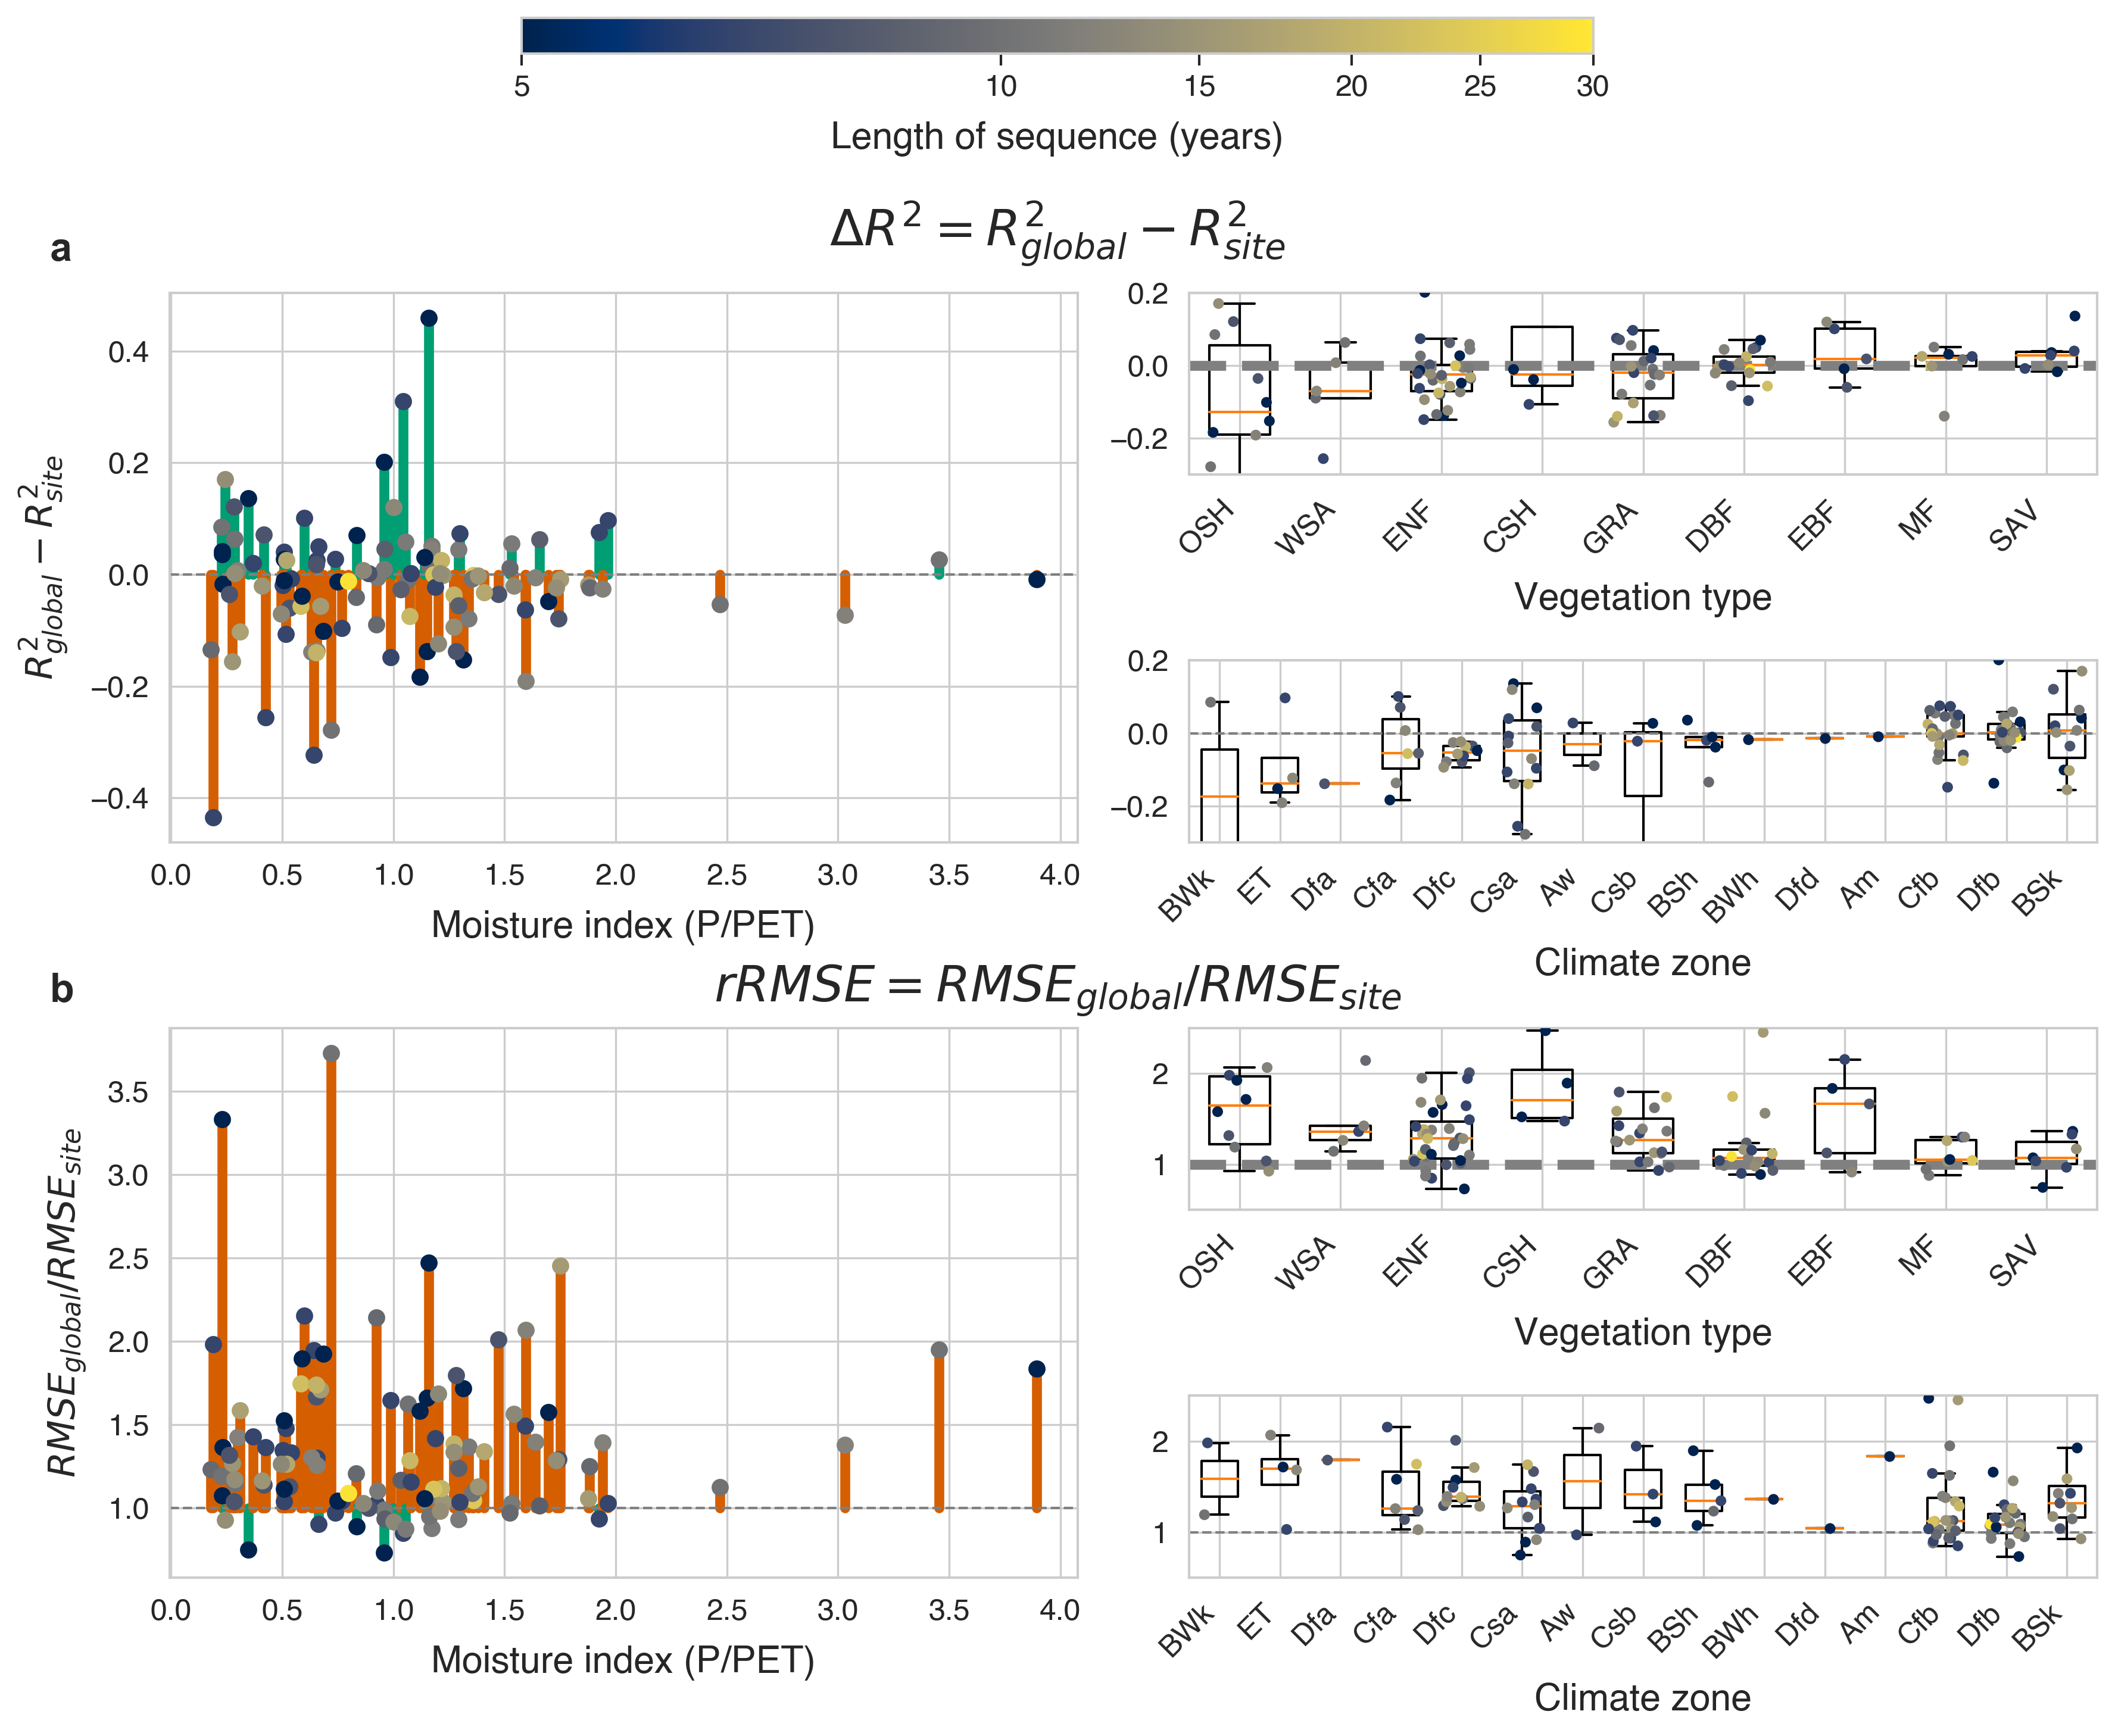

In [14]:
set_publication_style()
df_subset = site_metrics_df.copy()
df_subset['n_days'] = df.groupby('sitename').size().values
n_years = df_subset['n_days'] / 365

r2_first_values = df_subset['lstm_global_site_diff_r2']
veg_medians = df_subset.groupby('igbp_land_use')[r2_first_values.name].median()
veg_order = veg_medians.sort_values().index.tolist()
climate_medians = df_subset.groupby('koeppen_code')[r2_first_values.name].median()
climate_order = climate_medians.sort_values().index.tolist()

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(4, 2, height_ratios=[1, 1, 1, 1])
ax_r2_moisture = fig.add_subplot(gs[0:2, 0])
ax_r2_veg = fig.add_subplot(gs[0, 1])
ax_r2_climate = fig.add_subplot(gs[1, 1])
ax_rmse_moisture = fig.add_subplot(gs[2:4, 0])
ax_rmse_veg = fig.add_subplot(gs[2, 1])
ax_rmse_climate = fig.add_subplot(gs[3, 1])
ai_values = df_subset['ai']

cmap = plt.cm.cividis
norm = plt.Normalize(vmin=n_years.min(), vmax=n_years.max())
norm = plt_colors.PowerNorm(gamma=0.5, vmin=5, vmax=30)

metric_names = ['r2', 'rmse']
for idx, metric in enumerate(metric_names):
    if metric == 'r2':
        first_values = df_subset['lstm_global_site_diff_r2']
        baseline = 0
        ylabel = r'$R^2_{global} - R^2_{site}$'
        ax_moist = ax_r2_moisture
        ax_veg = ax_r2_veg
        ax_climate = ax_r2_climate
    elif metric == 'rmse':
        first_values = df_subset['lstm_global_site_ratio_rmse']
        baseline = 1
        ylabel = r'$RMSE_{global} / RMSE_{site}$'
        ax_moist = ax_rmse_moisture
        ax_veg = ax_rmse_veg
        ax_climate = ax_rmse_climate

    for aiv, val, yrs in zip(ai_values, first_values, n_years):
        if pd.notnull(val):
            lc = '#009E73' if (metric == 'r2' and val > 0) or (metric == 'rmse' and val < baseline) else '#D55E00'
            ax_moist.plot([aiv, aiv], [baseline, val], color=lc)
            ax_moist.scatter(aiv, val, color=cmap(norm(yrs)), marker='.', s=150, zorder=3)
    ax_moist.axhline(y=baseline, color='gray', linestyle='--', linewidth=1)
    ax_moist.set_xlabel('Moisture index (P/PET)')
    ax_moist.set_ylabel(ylabel)

    data_veg = [df_subset.loc[df_subset['igbp_land_use'] == cat, first_values.name].dropna() for cat in veg_order]
    x_veg = np.arange(len(data_veg))
    ax_veg.boxplot(data_veg, positions=x_veg, widths=0.6, showfliers=False)
    for i, cat in enumerate(veg_order):
        subset = df_subset[df_subset['igbp_land_use'] == cat]
        subset = subset[subset[first_values.name].notnull()]
        if not subset.empty:
            x_vals = np.full(len(subset), i) + np.random.uniform(-0.3, 0.3, len(subset))
            tmp_colors = cmap(norm(subset['n_days'] / 365))
            ax_veg.scatter(x_vals, subset[first_values.name], color=tmp_colors, marker='.', s=50, zorder=3)
    ax_veg.axhline(y=baseline, color='gray', linestyle='--')
    ax_veg.set_xticks(x_veg)
    ax_veg.set_xticklabels(veg_order, rotation=45, ha='right')
    ax_veg.set_xlabel('Vegetation type')

    data_climate = [df_subset.loc[df_subset['koeppen_code'] == cat, first_values.name].dropna() for cat in climate_order]
    x_climate = np.arange(len(data_climate))
    ax_climate.boxplot(data_climate, positions=x_climate, widths=0.6, showfliers=False)
    for i, cat in enumerate(climate_order):
        subset = df_subset[df_subset['koeppen_code'] == cat]
        subset = subset[subset[first_values.name].notnull()]
        if not subset.empty:
            x_vals = np.full(len(subset), i) + np.random.uniform(-0.3, 0.3, len(subset))
            tmp_colors = cmap(norm(subset['n_days'] / 365))
            ax_climate.scatter(x_vals, subset[first_values.name], color=tmp_colors, marker='.', s=50, zorder=3)
    ax_climate.axhline(y=baseline, color='gray', linestyle='--', linewidth=1)
    ax_climate.set_xticks(x_climate)
    ax_climate.set_xticklabels(climate_order, rotation=45, ha='right')
    ax_climate.set_xlabel('Climate zone')

    if metric == 'r2':
        ax_veg.set_ylim(-0.3, 0.2)
        ax_climate.set_ylim(-0.3, 0.2)
    elif metric == 'rmse':
        ax_veg.set_ylim(0.5, 2.5)
        ax_climate.set_ylim(0.5, 2.5)

fig.text(0.03, 0.84, 'a', ha='left', va='center', fontsize=16, fontweight='heavy', fontfamily='sans-serif')
fig.text(0.03, 0.425, 'b', ha='left', va='center', fontsize=16, fontweight='heavy', fontfamily='sans-serif')
plt.tight_layout(rect=[0, 0, 1, 0.84])
fig.text(0.5, 0.83, r'$\Delta R^2 = R^2_{global} - R^2_{site}$', ha='center', va='bottom', fontsize=20)
fig.text(0.5, 0.41, r'$rRMSE = RMSE_{global} / RMSE_{site}$', ha='center', va='bottom', fontsize=20)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.25, 0.95, 0.5, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Length of sequence (years)')
plt.show()

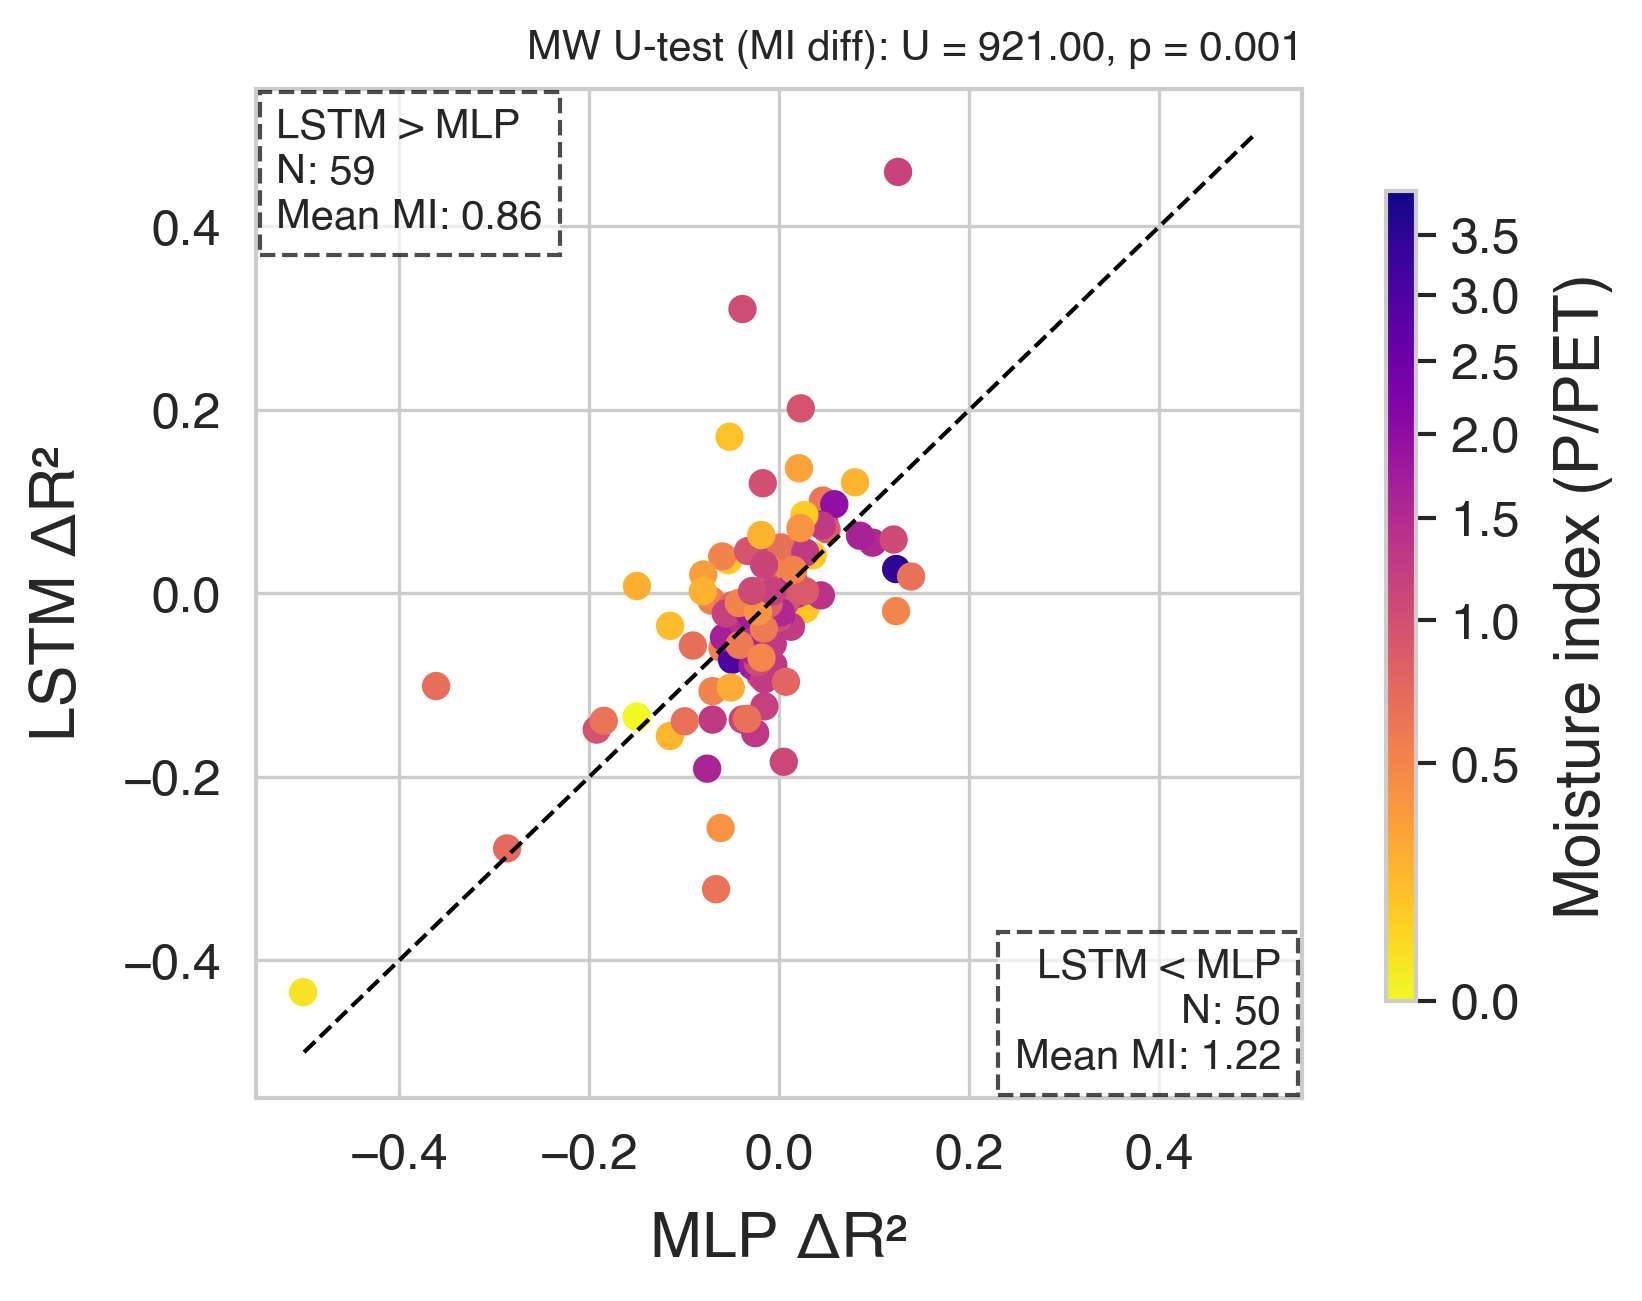

In [15]:
set_publication_style()
df_subset = site_metrics_df.copy()
norm = PowerNorm(gamma=0.5, vmin=df_subset["ai"].min(), vmax=df_subset["ai"].max())
n_lstm_gt_mlp = (df_subset['lstm_global_site_diff_r2'] > df_subset['mlp_global_site_diff_r2']).sum()
mean_ai_lstm_gt_mlp = df_subset[df_subset['lstm_global_site_diff_r2'] > df_subset['mlp_global_site_diff_r2']]['ai'].mean()
n_lstm_lt_mlp = (df_subset['lstm_global_site_diff_r2'] < df_subset['mlp_global_site_diff_r2']).sum()
mean_ai_lstm_lt_mlp = df_subset[df_subset['lstm_global_site_diff_r2'] < df_subset['mlp_global_site_diff_r2']]['ai'].mean()
fig, ax = plt.subplots(1, 1, figsize=(5,4.5))
sc = ax.scatter(df_subset['mlp_global_site_diff_r2'], df_subset['lstm_global_site_diff_r2'], c=df_subset['ai'], cmap='plasma_r', norm=norm)
ax.plot([-0.5, 0.5], [-0.5, 0.5], "k--", lw=1)
ax.set_xlabel('MLP ΔR²')
ax.set_ylabel('LSTM ΔR²')
text_gt_mlp = f"LSTM > MLP\nN: {n_lstm_gt_mlp}\nMean MI: {mean_ai_lstm_gt_mlp:.2f}"
text_lt_mlp = f"LSTM < MLP\nN: {n_lstm_lt_mlp}\nMean MI: {mean_ai_lstm_lt_mlp:.2f}"
bbox_props = dict(facecolor='white', alpha=0.7, edgecolor='black', linestyle='dashed', linewidth=1)
ax.text(0.02, 0.98, text_gt_mlp, transform=ax.transAxes, ha='left', va='top', fontsize=10, bbox=bbox_props)
ax.text(0.98, 0.02, text_lt_mlp, transform=ax.transAxes, ha='right', va='bottom', fontsize=10, bbox=bbox_props)
group_gt_mlp = df_subset[df_subset['lstm_global_site_diff_r2'] > df_subset['mlp_global_site_diff_r2']]['ai']
group_lt_mlp = df_subset[df_subset['lstm_global_site_diff_r2'] < df_subset['mlp_global_site_diff_r2']]['ai']
stat_mlp, p_val_mlp = stats.mannwhitneyu(group_gt_mlp, group_lt_mlp, alternative='two-sided')
ax.text(0.63, 1.02, f"MW U-test (MI diff): U = {stat_mlp:.2f}, p = {p_val_mlp:.3f}", transform=ax.transAxes, ha='center', va='bottom', fontsize=10)
plt.tight_layout(rect=[0, 0, 0.92, 1])
cbar_ax = fig.add_axes([0.94, 0.24, 0.02, 0.6])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label("Moisture index (P/PET)")
plt.show()

## Results 5: Performance with additional features

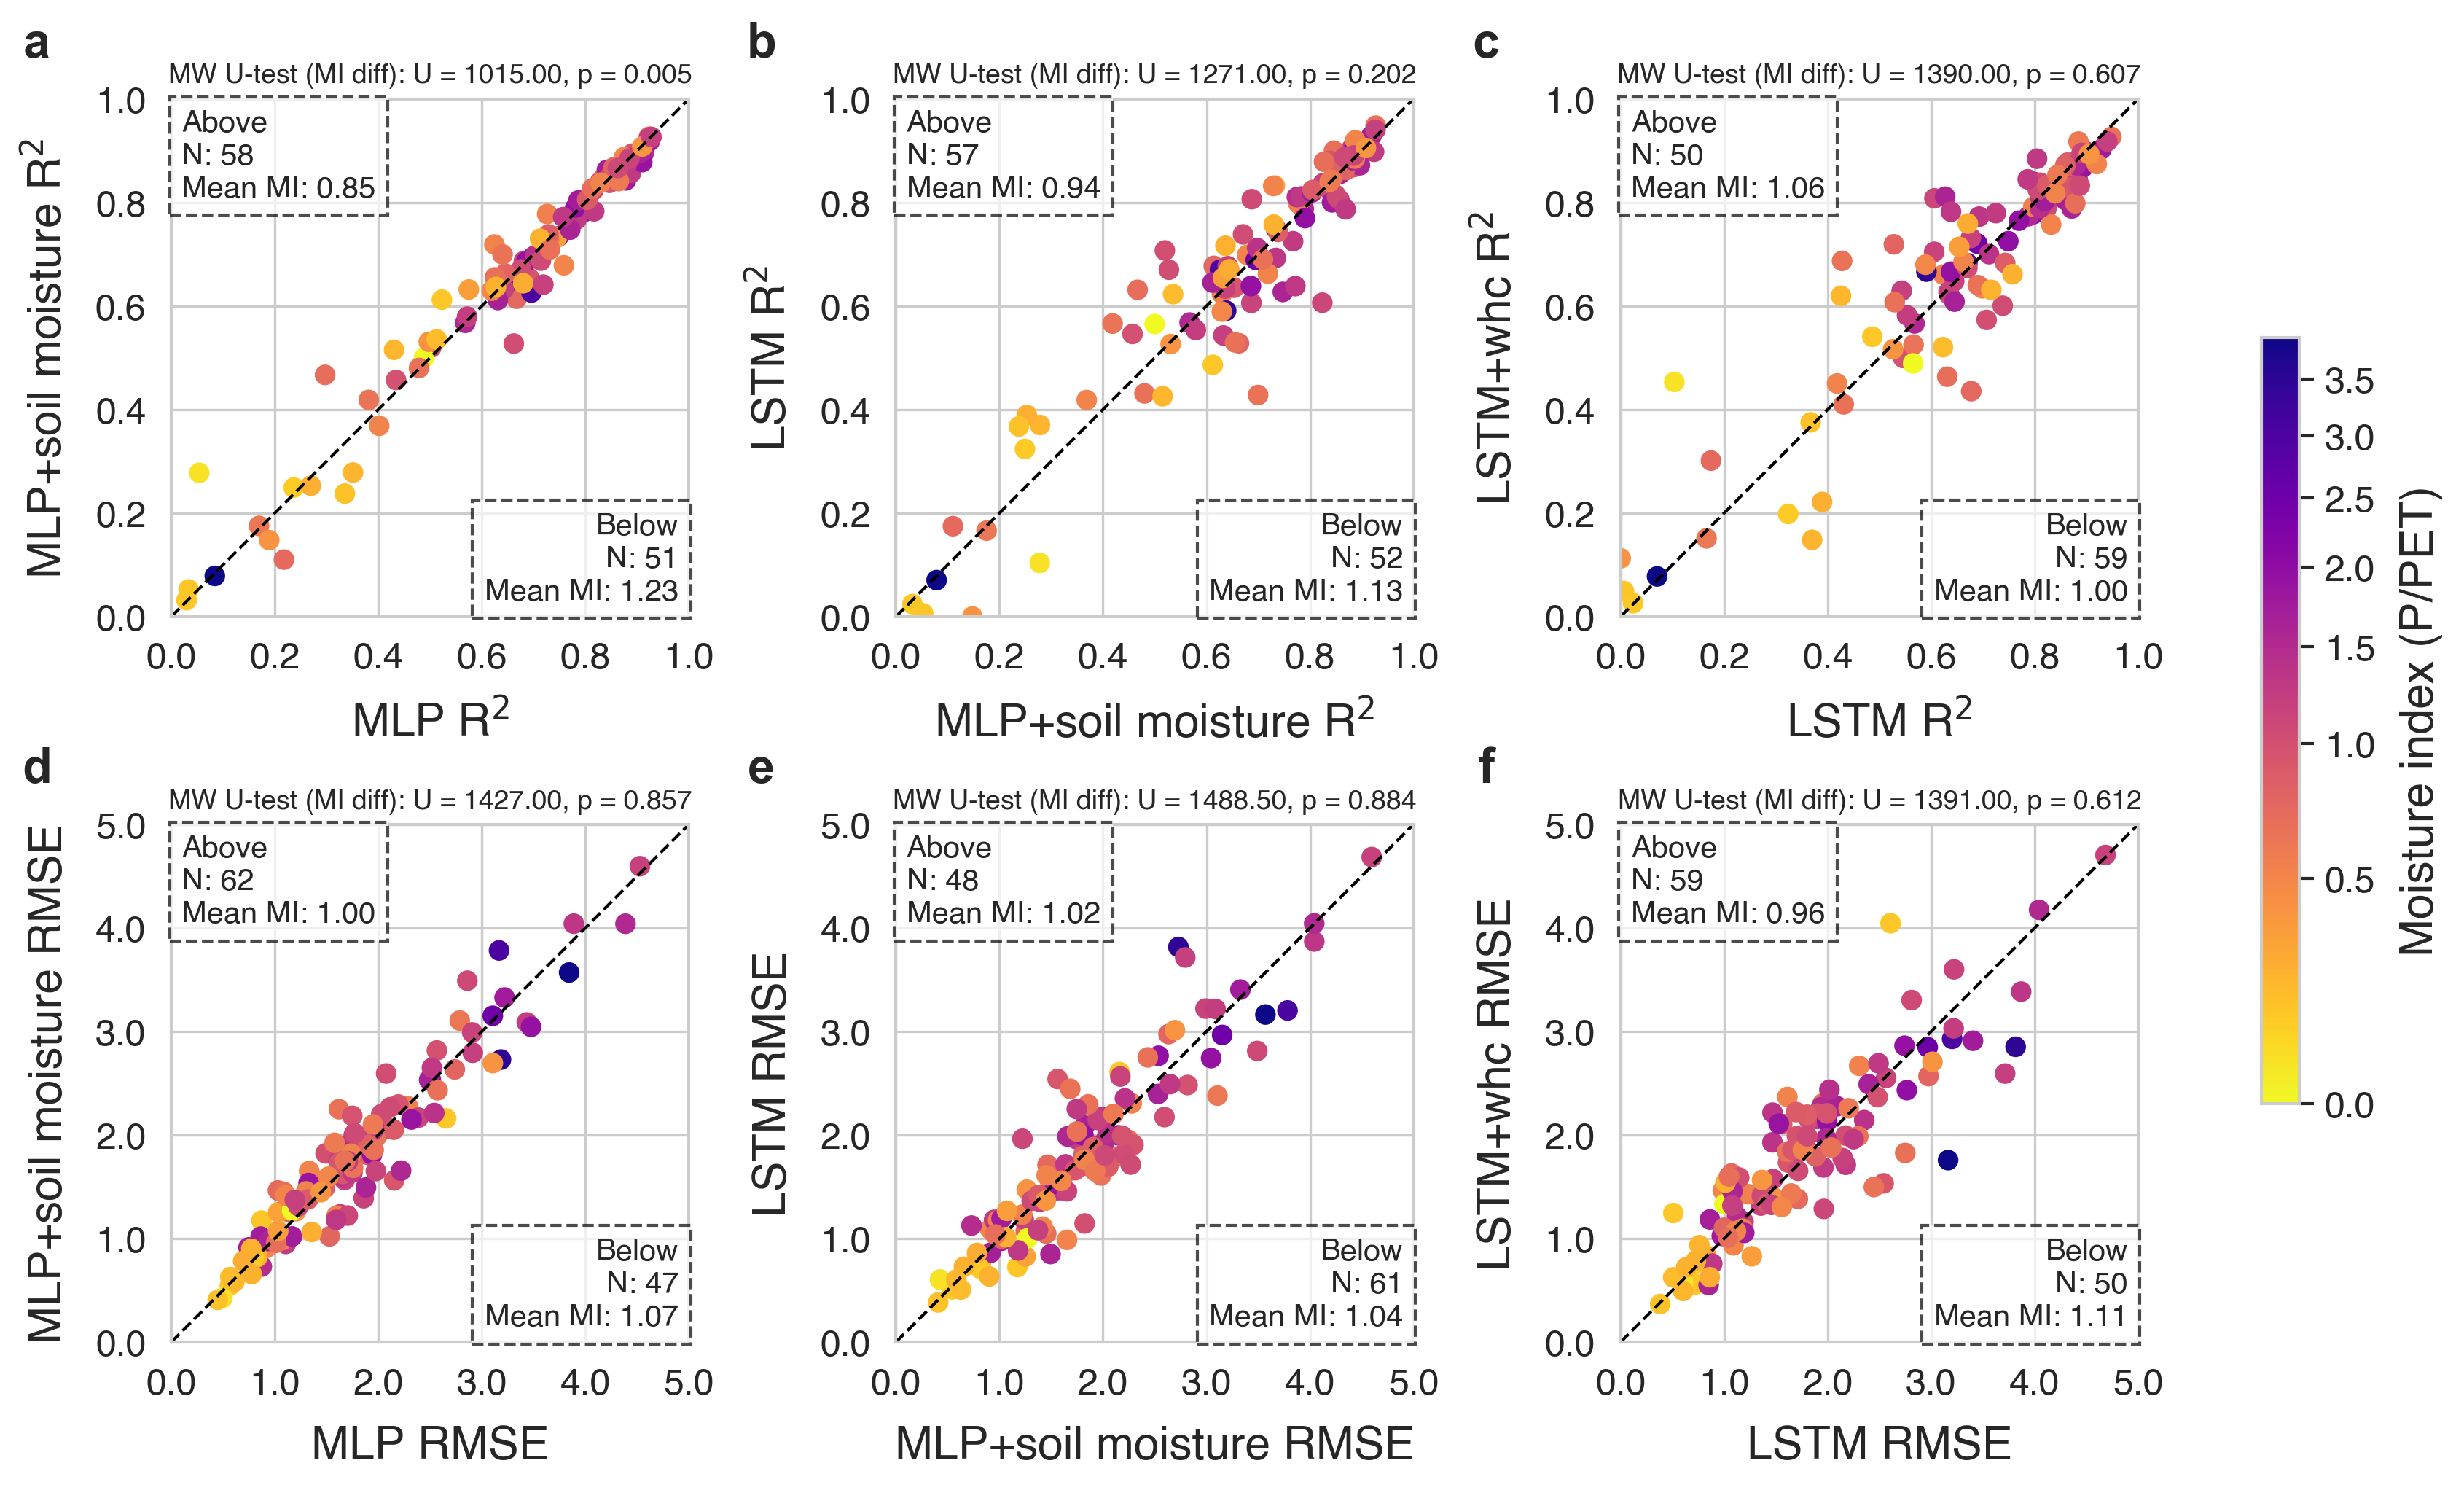

In [16]:
set_publication_style()
df_subset = site_metrics_df.copy()
norm = PowerNorm(gamma=0.5, vmin=df_subset["ai"].min(), vmax=df_subset["ai"].max())
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
sc = axes[0,0].scatter(df_subset["mlp_global_r2"], df_subset["mlp_global_extra_r2"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[0,0].plot([0,1], [0,1], "k--", lw=1)
axes[0,0].set_xlim(0,1)
axes[0,0].set_ylim(0,1)
axes[0,0].set_xticks([0,0.2,0.4,0.6,0.8,1])
axes[0,0].set_yticks([0,0.2,0.4,0.6,0.8,1])
axes[0,0].set_xlabel(r"MLP R$^2$")
axes[0,0].set_ylabel(r"MLP+soil moisture R$^2$")
sc = axes[0,1].scatter(df_subset["mlp_global_extra_r2"], df_subset["lstm_global_r2"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[0,1].plot([0,1], [0,1], "k--", lw=1)
axes[0,1].set_xlim(0,1)
axes[0,1].set_ylim(0,1)
axes[0,1].set_xticks([0,0.2,0.4,0.6,0.8,1])
axes[0,1].set_yticks([0,0.2,0.4,0.6,0.8,1])
axes[0,1].set_xlabel(r"MLP+soil moisture R$^2$")
axes[0,1].set_ylabel(r"LSTM R$^2$")
sc = axes[0,2].scatter(df_subset["lstm_global_r2"], df_subset["lstm_global_extra_r2"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[0,2].plot([0,1], [0,1], "k--", lw=1)
axes[0,2].set_xlim(0,1)
axes[0,2].set_ylim(0,1)
axes[0,2].set_xticks([0,0.2,0.4,0.6,0.8,1])
axes[0,2].set_yticks([0,0.2,0.4,0.6,0.8,1])
axes[0,2].set_xlabel(r"LSTM R$^2$")
axes[0,2].set_ylabel(r"LSTM+whc R$^2$")
sc = axes[1,0].scatter(df_subset["mlp_global_rmse"], df_subset["mlp_global_extra_rmse"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[1,0].plot([0,5], [0,5], "k--", lw=1)
axes[1,0].set_xlim(0,5)
axes[1,0].set_ylim(0,5)
axes[1,0].set_xticks([0,1,2,3,4,5])
axes[1,0].set_yticks([0,1,2,3,4,5])
axes[1,0].set_xticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,0].set_yticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,0].set_xlabel(r"MLP RMSE")
axes[1,0].set_ylabel(r"MLP+soil moisture RMSE")
sc = axes[1,1].scatter(df_subset["mlp_global_extra_rmse"], df_subset["lstm_global_rmse"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[1,1].plot([0,5], [0,5], "k--", lw=1)
axes[1,1].set_xlim(0,5)
axes[1,1].set_ylim(0,5)
axes[1,1].set_xticks([0,1,2,3,4,5])
axes[1,1].set_yticks([0,1,2,3,4,5])
axes[1,1].set_xticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,1].set_yticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,1].set_xlabel(r"MLP+soil moisture RMSE")
axes[1,1].set_ylabel(r"LSTM RMSE")
sc = axes[1,2].scatter(df_subset["lstm_global_rmse"], df_subset["lstm_global_extra_rmse"], c=df_subset["ai"], cmap="plasma_r", norm=norm, marker="o")
axes[1,2].plot([0,5], [0,5], "k--", lw=1)
axes[1,2].set_xlim(0,5)
axes[1,2].set_ylim(0,5)
axes[1,2].set_xticks([0,1,2,3,4,5])
axes[1,2].set_yticks([0,1,2,3,4,5])
axes[1,2].set_xticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,2].set_yticklabels([f"{tick:.1f}" for tick in [0,1,2,3,4,5]])
axes[1,2].set_xlabel(r"LSTM RMSE")
axes[1,2].set_ylabel(r"LSTM+whc RMSE")
for ax in axes.flatten():
    ax.set_aspect("equal", adjustable="box")
fig.tight_layout()
fig.subplots_adjust(right=0.85, wspace=0.4, hspace=-0.1)
letters = ["a", "b", "c", "d", "e", "f"]
for ax, letter in zip(axes.flatten(), letters):
    ax.text(-0.26, 1.15, letter, transform=ax.transAxes, fontsize=16, fontweight="heavy", fontfamily="sans-serif", va="top", ha="center", clip_on=False)
plots_info = [
    (axes[0,0], "mlp_global_r2", "mlp_global_extra_r2"),
    (axes[0,1], "mlp_global_extra_r2", "lstm_global_r2"),
    (axes[0,2], "lstm_global_r2", "lstm_global_extra_r2"),
    (axes[1,0], "mlp_global_rmse", "mlp_global_extra_rmse"),
    (axes[1,1], "mlp_global_extra_rmse", "lstm_global_rmse"),
    (axes[1,2], "lstm_global_rmse", "lstm_global_extra_rmse"),
]
bbox_props = dict(facecolor='white', alpha=0.7, edgecolor='black', linestyle='dashed', linewidth=1)
for ax, x_col, y_col in plots_info:
    above_mask = df_subset[y_col] > df_subset[x_col]
    below_mask = df_subset[y_col] < df_subset[x_col]
    above_count = above_mask.sum()
    below_count = below_mask.sum()
    mean_ai_above = df_subset.loc[above_mask, "ai"].mean()
    mean_ai_below = df_subset.loc[below_mask, "ai"].mean()
    text_above = f"Above\nN: {above_count}\nMean MI: {mean_ai_above:.2f}"
    text_below = f"Below\nN: {below_count}\nMean MI: {mean_ai_below:.2f}"
    ax.text(0.02, 0.98, text_above, transform=ax.transAxes, ha='left', va='top', fontsize=10, bbox=bbox_props)
    ax.text(0.98, 0.02, text_below, transform=ax.transAxes, ha='right', va='bottom', fontsize=10, bbox=bbox_props)
    group_above = df_subset.loc[above_mask, "ai"]
    group_below = df_subset.loc[below_mask, "ai"]
    stat, p_val = stats.mannwhitneyu(group_above, group_below, alternative='two-sided')
    ax.text(0.5, 1.02, f"MW U-test (MI diff): U = {stat:.2f}, p = {p_val:.3f}", transform=ax.transAxes, ha='center', va='bottom', fontsize=9)
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.5)
cbar.set_label("Moisture index (P/PET)")
plt.show()

## Appendix

In [17]:
site_metrics_df['delayed_gpp'] = site_metrics_df['cold_acclimation_type'].apply(lambda x: True if x == 'cold_delayedgpp' else (False if x == 'cold_nodelayedgpp' else ''))
site_metrics_df['ai'] = site_metrics_df['ai'].round(2)
site_metrics_df['period'] = site_metrics_df['start_year'].astype(str) + '-' + site_metrics_df['end_year'].astype(str)
site_metrics_df['reference?'] = ''
df_renamed = site_metrics_df.rename(columns={'igbp_land_use': 'igbp','koeppen_code': 'climate zone','is_evergreen': 'evergreen','ai': 'moisture_index','delayed_gpp': 'delayed GPP'})
cols = ['sitename','period','moisture_index','climate zone','igbp','evergreen','delayed GPP']
rename_dict = {'sitename': 'Sitename','period': 'Period','igbp': 'Veg.','climate zone': 'Clim.','evergreen': 'Evergreen','moisture_index': 'MI','delayed GPP': 'Delayed GPP'}
latex_table_raw = df_renamed[cols].rename(columns=rename_dict).to_latex(index=False)
latex_table_raw = latex_table_raw.replace("\\toprule","\\hline").replace("\\midrule","\\hline").replace("\\bottomrule","\\hline")
latex_table_supertabular = latex_table_raw.replace("\\begin{tabular}", "\\begin{supertabular}").replace("\\end{tabular}", "\\end{supertabular}")
lines = latex_table_supertabular.splitlines()
toprule_idx = None
midrule_idx = None
for i, line in enumerate(lines):
    if '\\hline' in line and toprule_idx is None:
        toprule_idx = i
    elif '\\hline' in line and toprule_idx is not None and midrule_idx is None:
        midrule_idx = i
        break
header_lines = lines[toprule_idx:midrule_idx+1]
header_str = "\n".join(header_lines)
bottomrule_idx = None
for i, line in enumerate(lines):
    if '\\hline' in line and i > midrule_idx:
        bottomrule_idx = i
content_lines = lines[:toprule_idx] + lines[midrule_idx+1:bottomrule_idx] + lines[bottomrule_idx+1:]
begin_supertab_idx = None
for i, line in enumerate(content_lines):
    if '\\begin{supertabular}' in line:
        begin_supertab_idx = i
        break
match = re.search(r'\\begin{supertabular}\{(.+?)\}', content_lines[begin_supertab_idx])
if match:
    colspec = match.group(1)
    num_cols = sum(1 for c in colspec if c.isalpha())
else:
    num_cols = len(cols)
tablefirsthead = r"\tablefirsthead{" + "\n" + header_str + "\n" + "}"
tablehead = r"\tablehead{" + "\n" + header_str + "\n" + "}"
tabletail = r"\tabletail{" + "\n" + r"\hline" + "\n" + r"\multicolumn{" + str(num_cols) + r"}{r}{\textit{Continued on next page}}\\" + "\n" + r"\hline" + "\n" + "}"
tablelasttail = r"\tablelasttail{" + "\n" + r"\hline" + "\n" + "}"
new_content_lines = []
for i, line in enumerate(content_lines):
    if i == begin_supertab_idx:
        new_content_lines.append(tablefirsthead)
        new_content_lines.append(tablehead)
        new_content_lines.append(tabletail)
        new_content_lines.append(tablelasttail)
    new_content_lines.append(line)
final_content = "\n".join(new_content_lines)
print(final_content)

\tablefirsthead{
\hline
Sitename &    Period &   MI & Clim. & Veg. &  Evergreen & Delayed GPP \\
\hline
}
\tablehead{
\hline
Sitename &    Period &   MI & Clim. & Veg. &  Evergreen & Delayed GPP \\
\hline
}
\tabletail{
\hline
\multicolumn{7}{r}{\textit{Continued on next page}}\\
\hline
}
\tablelasttail{
\hline
}
\begin{supertabular}{llrllll}
  AT-Neu & 2002-2012 & 1.34 &   Dfc &  GRA &      False &             \\
  AU-ASM & 2012-2016 & 0.23 &   BSh &  SAV &      False &             \\
  AU-Cow & 2010-2014 & 3.89 &    Am &  EBF &       True &             \\
  AU-Cum & 2013-2018 & 0.60 &   Cfa &  EBF &       True &             \\
  AU-DaS & 2012-2017 & 0.74 &    Aw &  SAV &      False &             \\
  AU-GWW & 2013-2017 & 0.23 &   BWh &  SAV &      False &             \\
  AU-Gin & 2012-2017 & 0.42 &   Csa &  WSA &      False &             \\
  AU-How & 2009-2017 & 0.92 &    Aw &  WSA &      False &             \\
  AU-Stp & 2011-2016 & 0.50 &   BSh &  GRA &      False &             \\

/var/folders/6c/5dxqj_g920qdcjvrhqv6vljh0000gn/T/ipykernel_33786/2322702049.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_raw = df_renamed[cols].rename(columns=rename_dict).to_latex(index=False)
